# Initialization

- import of libraries neede
- definition of global variables


## Assumptions 
- The Dependency-Track API key has been added to the `.env` file with the name `DEPENDENCY_TRACK_API_KEY`.
- The notebook needs to be **connected to Roche VPN** to access Dependency-Track and Defect Dojo`

- For **WSL2** users, `wsl-vpnkit` needs to be installed and started from PowerShell using the following command:

```bash
wsl.exe -d wsl-vpnkit --cd /app wsl-vpnkit
```

In [1]:
import requests
import warnings
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
from pprint import pprint

from dependency_track import DependencyTrack as dt   # to connect with DependencyTrack and get project_info and project_data
from visualization import *                          # to create visualizations
from dataframe_filters import *                      # to filter data frames

# Deactivate warning from SSL certificates           # to remove SSL warnings
warnings.filterwarnings('ignore') 

# Create DependencyTrack instance
# this connects with dependency-track and downloads project info (name, version, UUID) for all projects
dt_instance = dt()                                   # connect with dependency-track and download project info (name, version, 
                                                     # UUID) and persist in dt_instance.project_info and in file project_info.csv"



# List of projects in scope (Name, Version)
in_scope = [('Floodlight', None),
            ('Generator_2', None),
            ('iEdgeMicroService', None),
            ('Juice_Shop', None),
            ('NMP', None),
            ('pm-dashboard-frontend', None),
            ('pm-lst-kpi-module', None),
            ('pm-mongo', None),
            ('RDCS_RDCP-Client', None),
            ('RT-Cosmo', None),
            ('Vulnerable_Flask_App', 0.2),
            ('Vulnerable_Flask_App', 1.2),
            ('WebGoat', None)
           ]


dt_instance.project_info

,Name,Version,UUID
0,DD Integration,None,26b6f86a-a4b9-49b4-94fb-688cba7fb117
1,Floodlight_gitlab_cont,None,7ecb1271-7b7a-428b-aa85-9d7695d74654
2,Floodlight_jfrog_advanced_security_cont,None,7f05c871-c4b1-4171-bb6e-361d17246ca4
3,Floodlight_jfrog_cont,None,1fc23e96-bef8-4d07-b45f-9348f5a22e9a
4,Floodlight_syft_cont,None,a969a2e1-7fa5-44e6-802e-af571745a275
...,...,...,...
94,WebGoat_jfrog_advanced_security_cont,None,46fe530b-ddee-45ec-9514-a0545893da07
95,WebGoat_jfrog_cont,None,14241678-9721-48a9-85c4-54a283706421
96,WebGoat_syft_cont,None,385f0aa0-2f8c-4a6b-847a-fe098826398f
97,WebGoat_trivy_cont,None,5b8c9f7a-d3d8-4fcf-9089-19f3569162c5


## Creat aggregated SBOM data 

Get the scanner data for all projects defined in variable `in_scope`.
The data frames are collected in a list combined_dfs and added to the aggregrated data frame
`scanner_data_agg_df` for later analysis

To identify equality the last name from the string in field name is used (see proc1(x)) and concatenated with the versionrsion']

```python
df["name"].apply(proc1) + ':' +  df['version']
```

In [2]:
# define project name and target field 
DISPLAY = True

# Custom function for the transformation of JFrog artifact names and pull out the version
def process_string(s):
    if s.endswith(".jar"):
        s = s[:-4]  # Remove ".jar"
        parts = s.split("-")
        new_name = "-".join(parts[:])
        new_version = None 
        for i in range(0, len(parts) - 1, 1):
            if parts[i+1].replace(".", "").replace("_","").isdigit():
                new_version = "-".join(parts[i+1:])
                new_name = "-".join(parts[:i+1])   
                break
        return new_name, new_version 
    else:
        return None, None

def transform_row(row):
    if row['new_name'] is not None:
        row['name'] = row['new_name']
    if row['new_version'] is not None:
        row['version'] = row['new_version']
    return row



# Initialize an empty list to hold the concatenated DataFrames
combined_dfs = []

for project_name, project_version in in_scope:
    
    print(f"Project: {project_name} version {project_version}")
    
    # get project data in data frame
    project_scanner_data = dt_instance.collect_all_scanner_data(project_name, project_version)

    # Dictionary to store the counted values
    counted_values = {}

    # Iterate through the dictionary values (DataFrames) and add to list of dfs
    for scanner, df in project_scanner_data.items():
        df['project_name'] = project_name
        df['project_version'] = project_version

        # Preprocess JFrog scanners to extract the version numbers from the filename
        if scanner in ['jfrog_advanced_security_cont', 'jfrog_cont']:
            df['new_name'], df['new_version'] = zip(*df['name'].apply(process_string))
            # Copy the new identified names and version back
            df = df.apply(transform_row, axis=1)
            # Drop the 'new_name' and 'new_version' columns if needed
            df.drop(columns=['new_name', 'new_version'], inplace=True)
        
        # Add a columne with project name and version information
        df['project_name_version'] = np.where(pd.isna(df['project_version']), 
                                              df['project_name'].astype(str), 
                                              df['project_name'].astype(str) + '_' + df['project_version'].astype(str))
        
        # Extract the last part of the 'name' column and combine it with the 'version' column
        df['name_version'] = (df['name'].apply(lambda x: x.split(':')[-1]).astype(str) + 
                              ':' + 
                              df['version'].fillna('').astype(str))
        combined_dfs.append(df)
        
#    # Apply the function proc1 to column "name" and add the result as column "name_proc1" using .assign()
#    project_scanner_data = {df_name: df.assign(name_version=(df["name"].apply(proc1).astype(str) + ':' + 
#                                                                   df['version'].fillna('').astype(str)))  
#                            for df_name, df in project_scanner_data.items()}

# Concatenate the DataFrames along the rows (vertically)
scanner_data_agg_df = pd.concat(combined_dfs, ignore_index=True)
scanner_data_agg_df.reset_index(drop=True, inplace=True)

# Persist data as csv file
scanner_data_agg_df.to_csv("SBOM_scanner_data_agg.csv")

Project: Floodlight version None
Project: Generator_2 version None
Project: iEdgeMicroService version None
Project: Juice_Shop version None
Project: NMP version None
Project: pm-dashboard-frontend version None
Project: pm-lst-kpi-module version None
Project: pm-mongo version None
Project: RDCS_RDCP-Client version None
Project: RT-Cosmo version None
Project: Vulnerable_Flask_App version 0.2
Project: Vulnerable_Flask_App version 1.2
Project: WebGoat version None


## Create confusion matrices

In [3]:
columns = ['project_name_version', 'scanner_name', 'name_version', 'name', 'version']
scanner_data_df = scanner_data_agg_df[columns].copy()

# Mark the artifacts identified by the scanners
scanner_data_df['flag'] = 1

project_version_grouped = scanner_data_df.groupby(['project_name_version'], dropna=False)

# Initialize an empty list to hold the concatenated DataFrames
combined_dfs = []

for project_name_version, project_version_group in project_version_grouped:
        
    print(f"Evaluating data for confusion matrix of project: {project_name_version[0]}")

    # Drop all artifacts without version number
    project_version_group.dropna(subset=['version'], inplace=True)

    # Get all unique artifacts
    all_artifacts = project_version_group['name_version'].unique()

    # Initialize an empty list to hold data for the final DataFrame
    data_final = []

    # Group by 'name' and 'type'
    scanner_grouped = project_version_group.groupby(['scanner_name'])

    # Iterate through groups
    for scanner_name, scanner_df in scanner_grouped:

        # Evaluate missing 'name_version'
        missing_artifacts = set(all_artifacts) - set(scanner_df['name_version'])
    
        # Append rows for missing UUIDs
        for artifact in missing_artifacts:
            data_final.append({'project_name_version': project_name_version[0], 
                               'scanner_name': scanner_name[0], 
                               'name_version': artifact, 
                               'flag': 0})
  
        # Append the original group
        data_final.extend(scanner_df.to_dict(orient='records'))
 

    # Create the final DataFrame and persist it
    confusion_matrix_df = pd.DataFrame(data_final)

    # Drop 'name' and 'version' and duplicates for 'name_version' and 'scanner_name'
    confusion_matrix_df = confusion_matrix_df.drop(columns=['name', 'version'])              # 'name' and 'version are not needed
    confusion_matrix_df = confusion_matrix_df.drop_duplicates(subset=['name_version', 'scanner_name'])  # 'remove duplicates

    # Automatic labeling (if more then 'true_threshold' scanners vote for an artifact it is considered a true positive
    result_counts = confusion_matrix_df.groupby('name_version')['flag'].sum()
    result_counts = result_counts.to_frame(name='vote')

    true_threshold = 3    # set the threshold for voting
    result_counts['label'] = [1 if vote >= true_threshold else 0 for vote in result_counts['vote']]

    # Merge back into the confusion matrix
    confusion_matrix_df = confusion_matrix_df.merge(result_counts[['label', 'vote']], left_on='name_version', right_index=True)
    combined_dfs.append(confusion_matrix_df)

confusion_matrix_agg_df = pd.concat(combined_dfs,ignore_index=True)
confusion_matrix_agg_df.reset_index(drop=True, inplace=True)

confusion_matrix_agg_df.to_csv("SBOM_confusion_matrix_agg.csv")

Evaluating data for confusion matrix of project: Floodlight
Evaluating data for confusion matrix of project: Generator_2
Evaluating data for confusion matrix of project: Juice_Shop
Evaluating data for confusion matrix of project: NMP
Evaluating data for confusion matrix of project: RDCS_RDCP-Client
Evaluating data for confusion matrix of project: RT-Cosmo
Evaluating data for confusion matrix of project: Vulnerable_Flask_App_0.2
Evaluating data for confusion matrix of project: Vulnerable_Flask_App_1.2
Evaluating data for confusion matrix of project: WebGoat
Evaluating data for confusion matrix of project: iEdgeMicroService
Evaluating data for confusion matrix of project: pm-dashboard-frontend
Evaluating data for confusion matrix of project: pm-lst-kpi-module
Evaluating data for confusion matrix of project: pm-mongo


### Debug

## Visualization

### Visualize SBOM similarity

Evaluating data for confusion matrix of project: Floodlight - None.


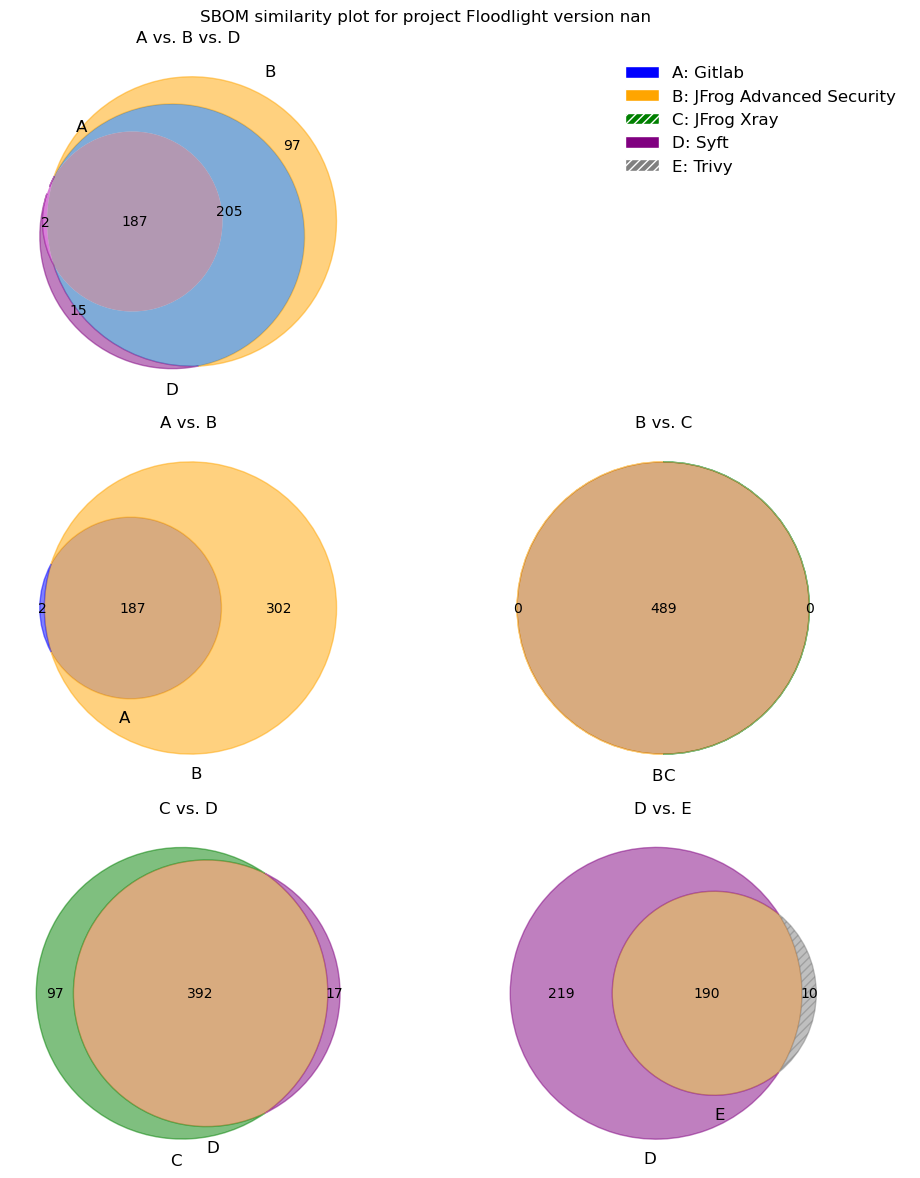

Evaluating data for confusion matrix of project: Generator_2 - None.


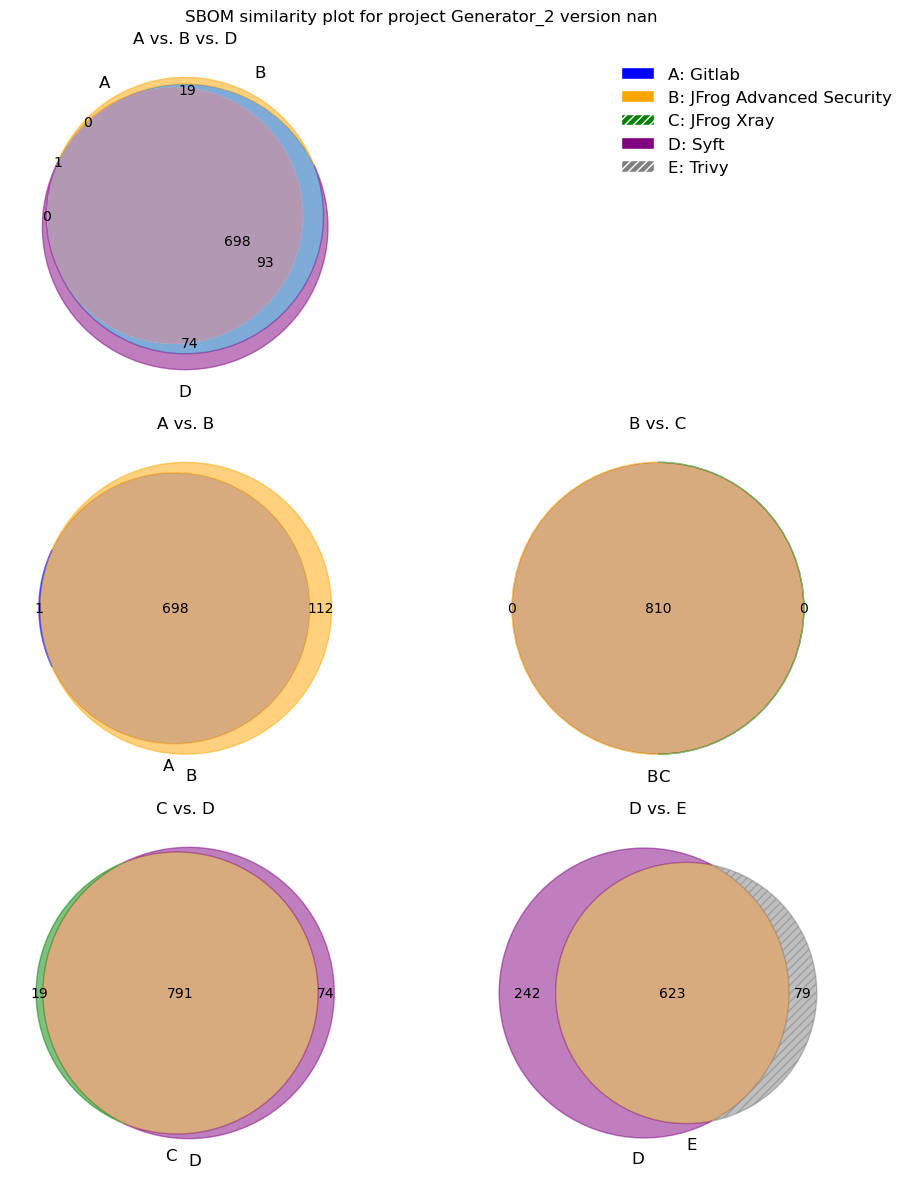

Evaluating data for confusion matrix of project: Juice_Shop - None.


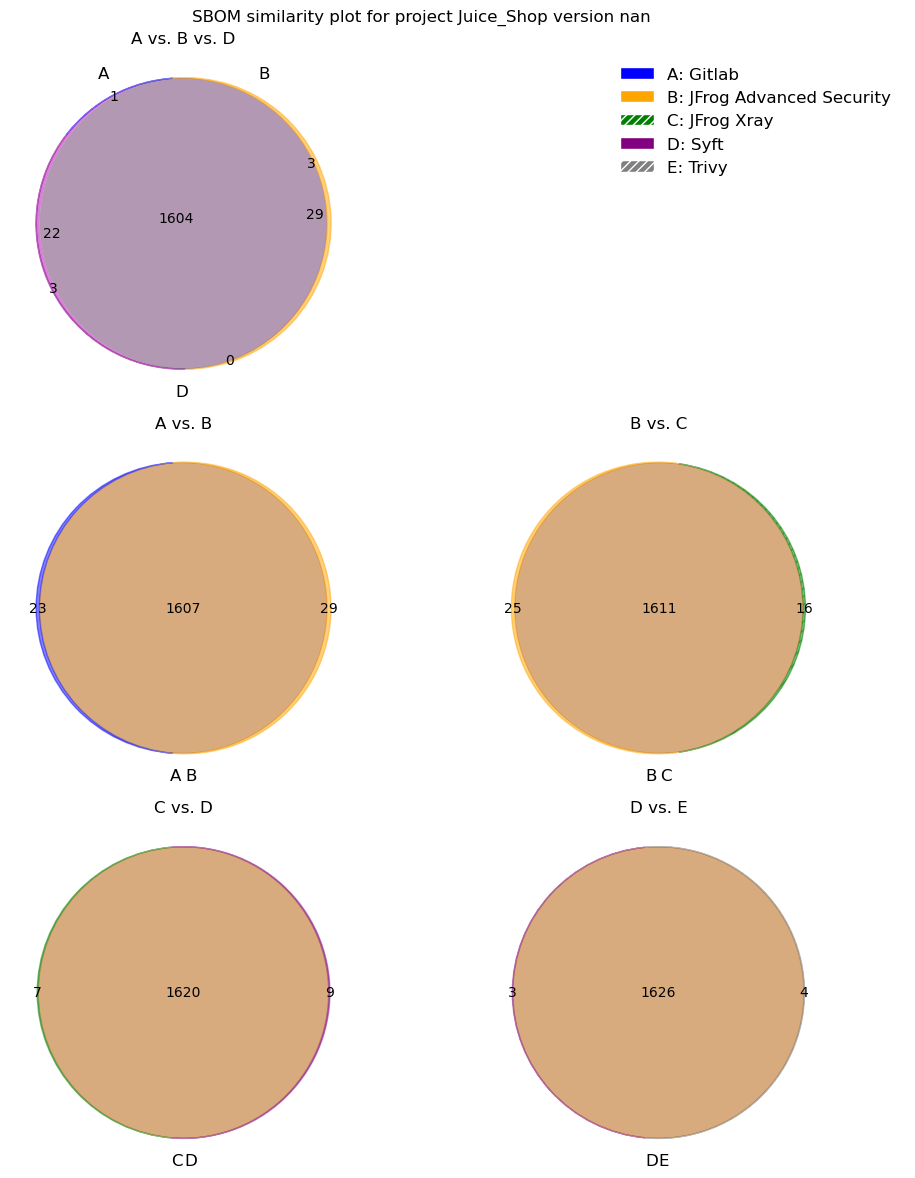

Evaluating data for confusion matrix of project: NMP - None.


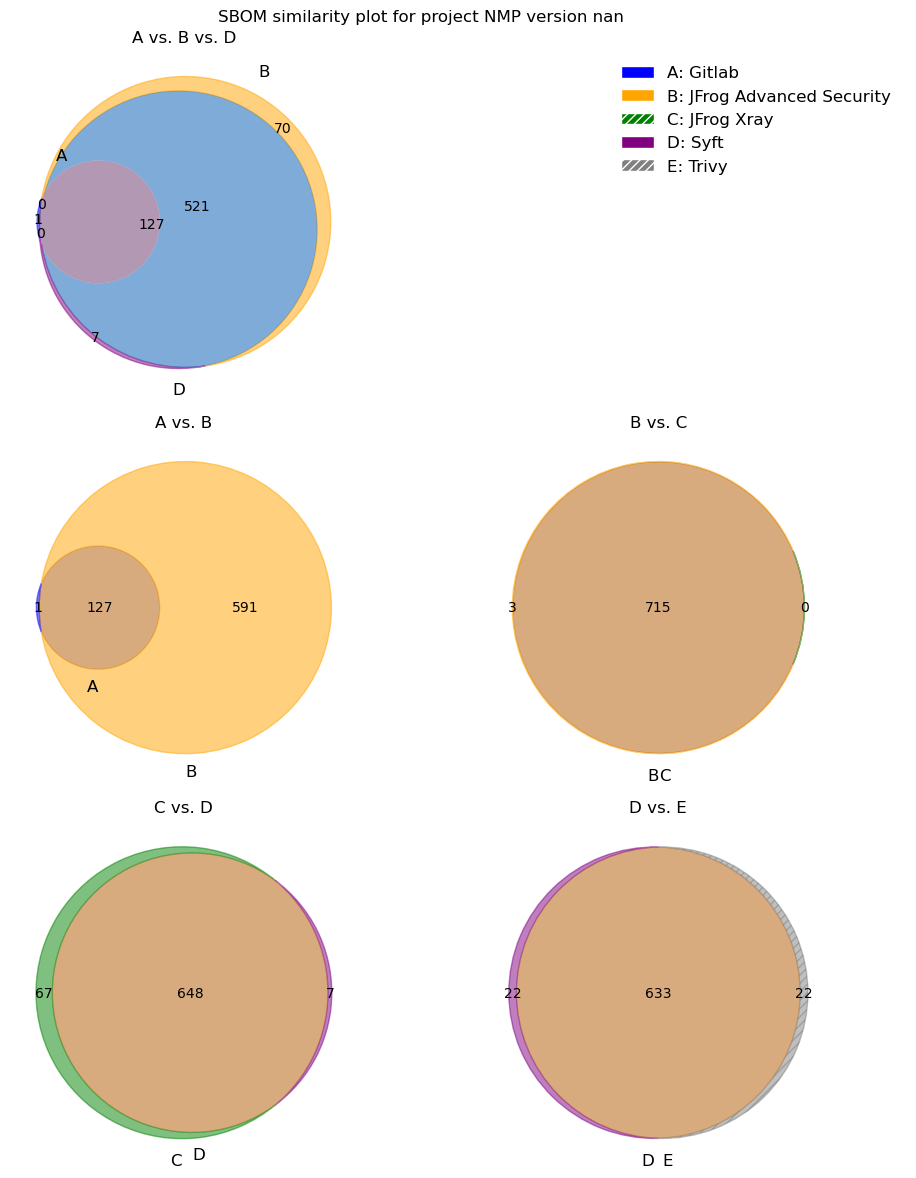

Evaluating data for confusion matrix of project: RDCS_RDCP-Client - None.


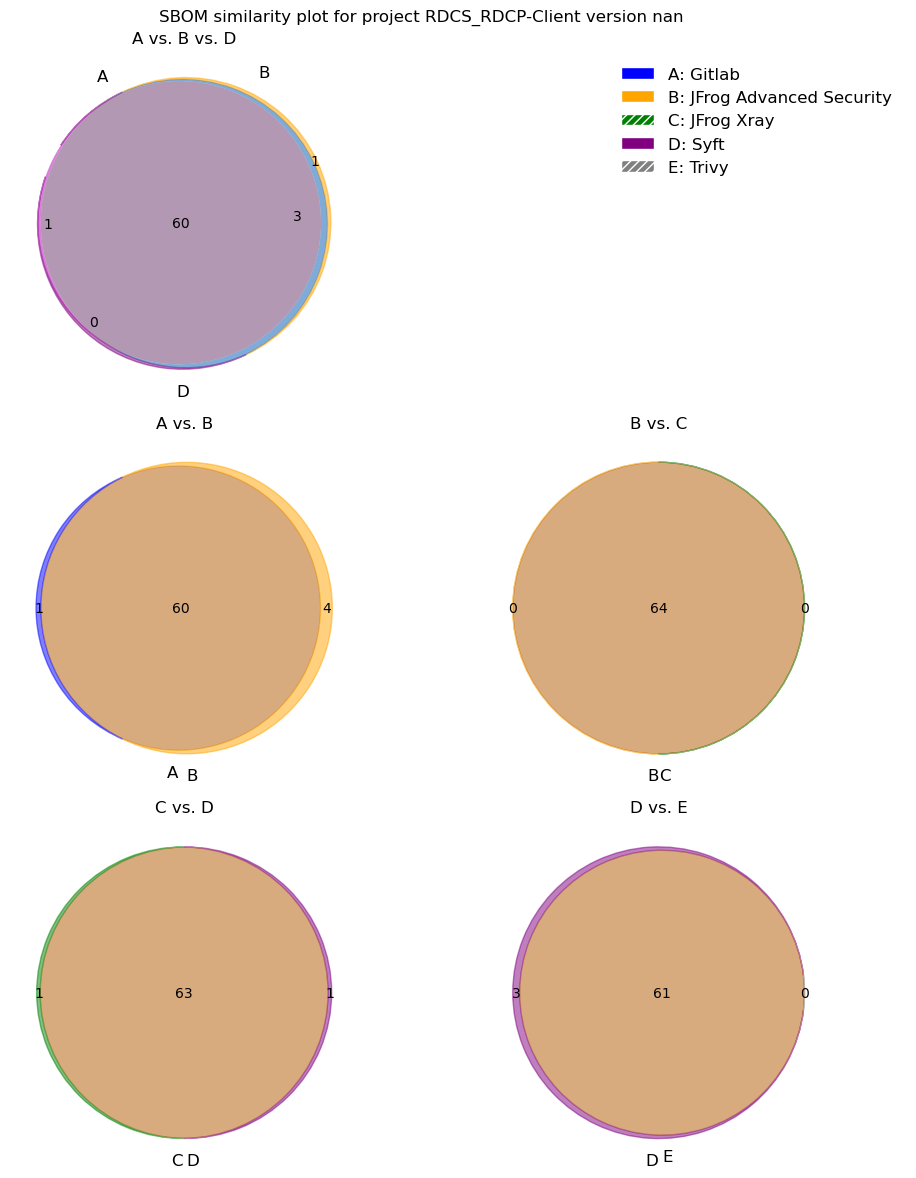

Evaluating data for confusion matrix of project: RT-Cosmo - None.


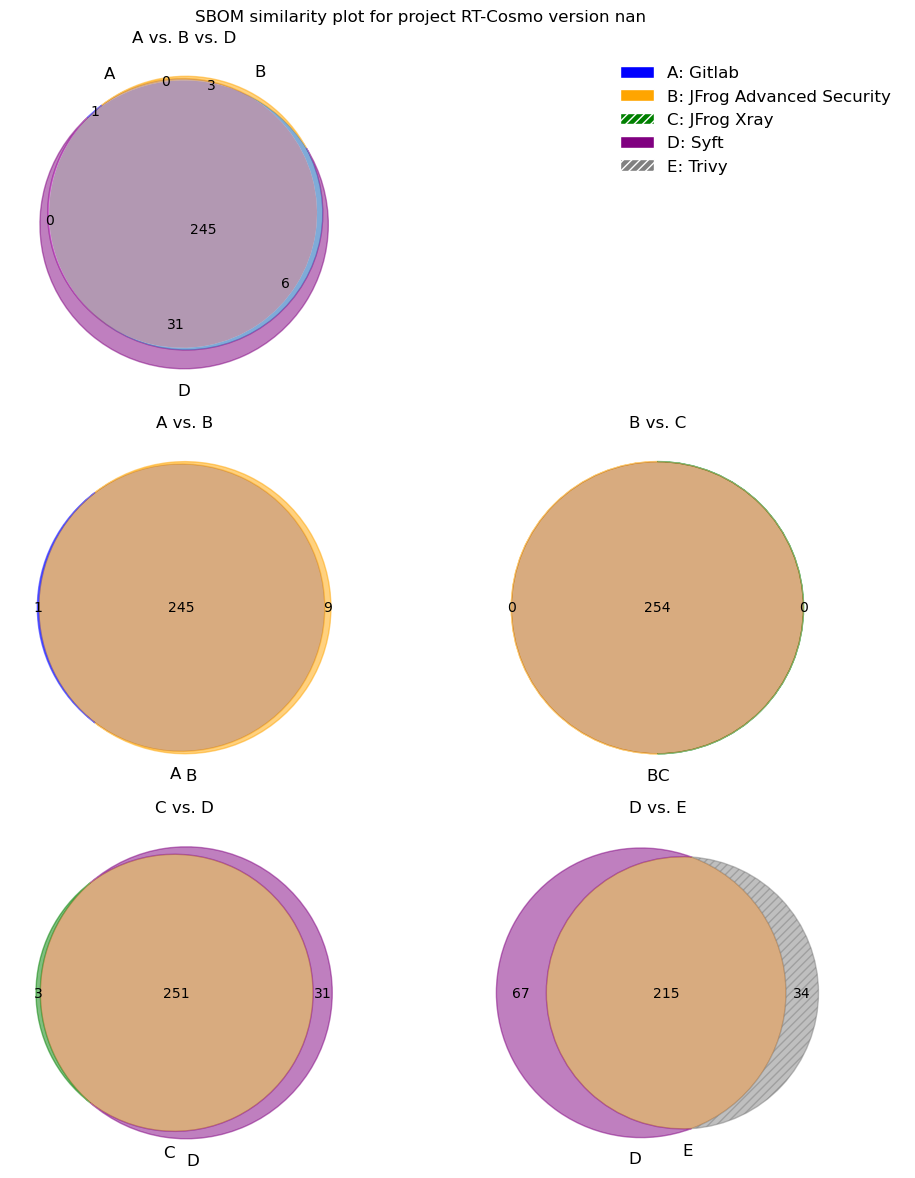

Evaluating data for confusion matrix of project: Vulnerable_Flask_App - 0.2.
debug: <class 'numpy.float64'>


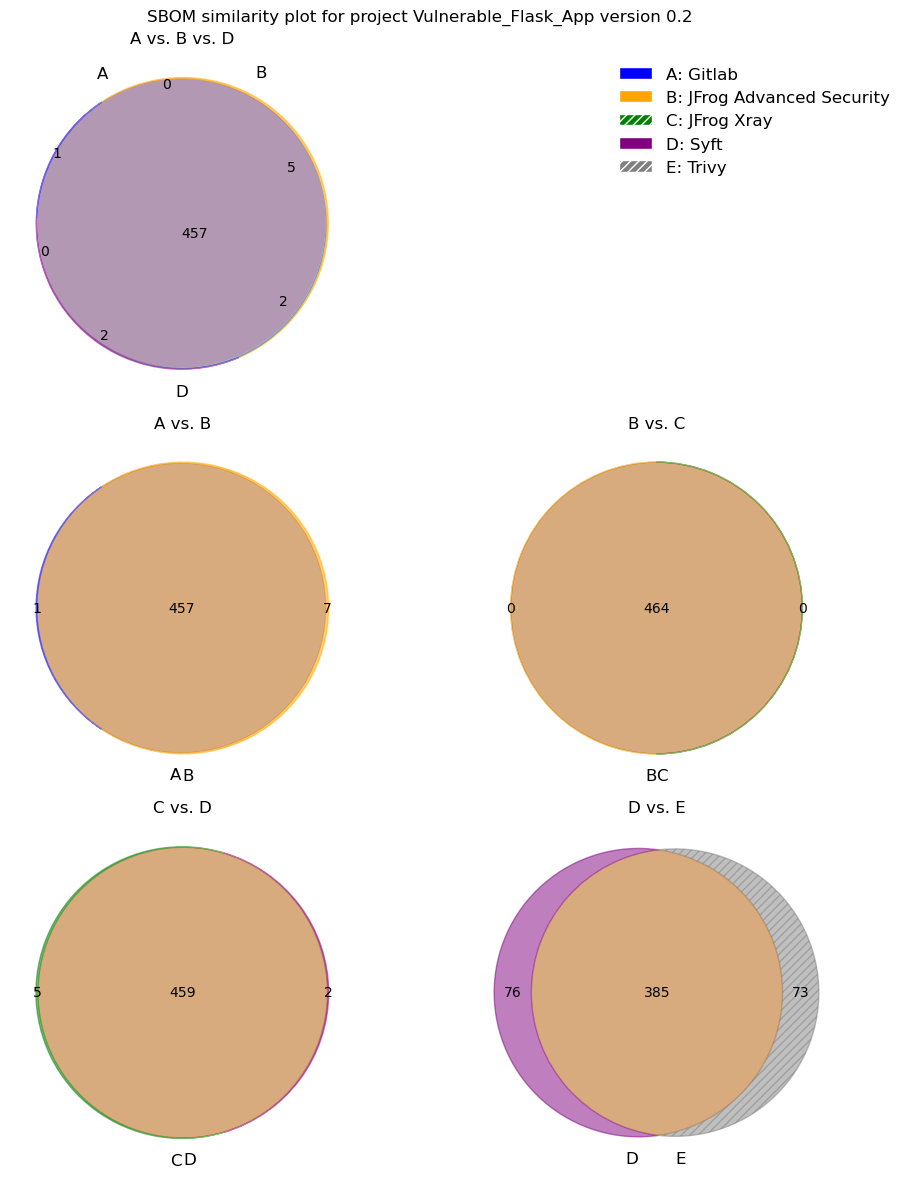

Evaluating data for confusion matrix of project: Vulnerable_Flask_App - 1.2.
debug: <class 'numpy.float64'>


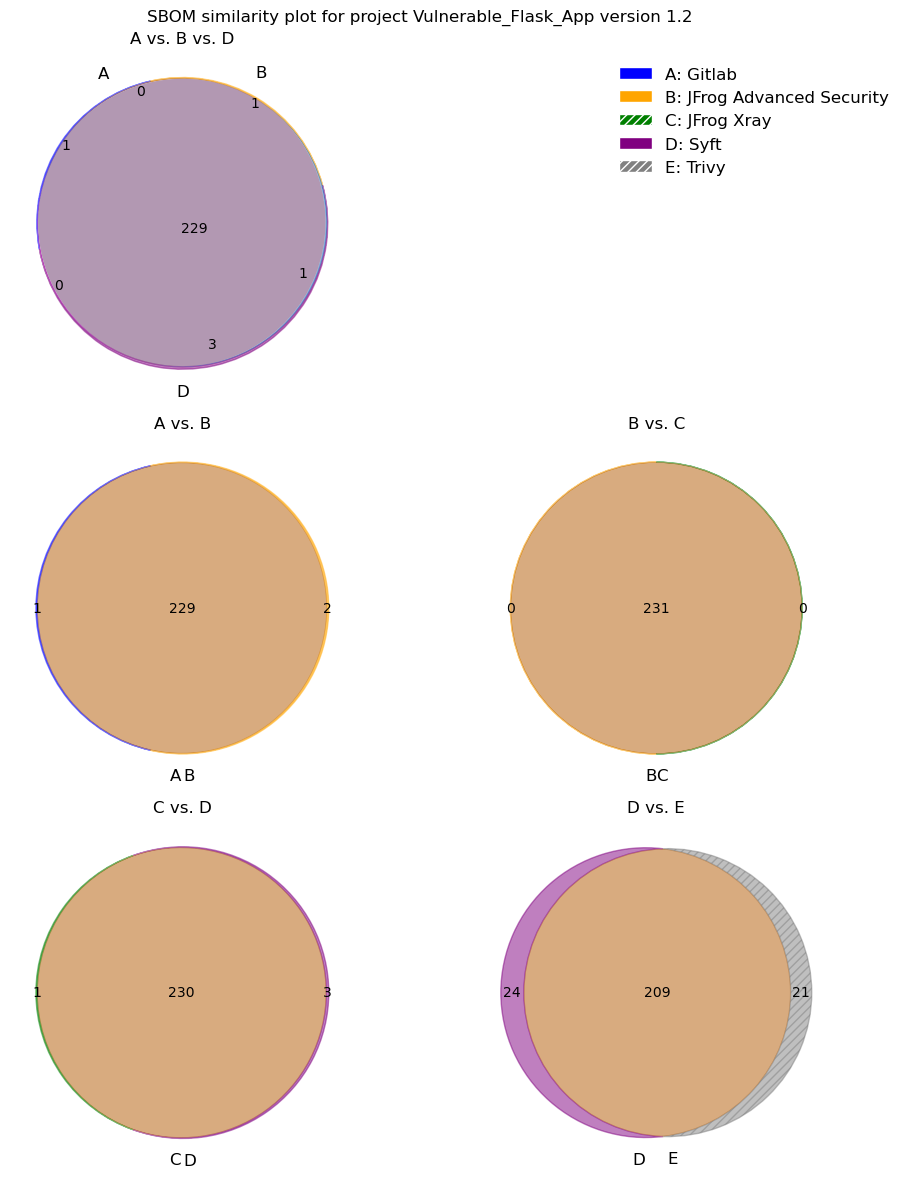

Evaluating data for confusion matrix of project: WebGoat - None.


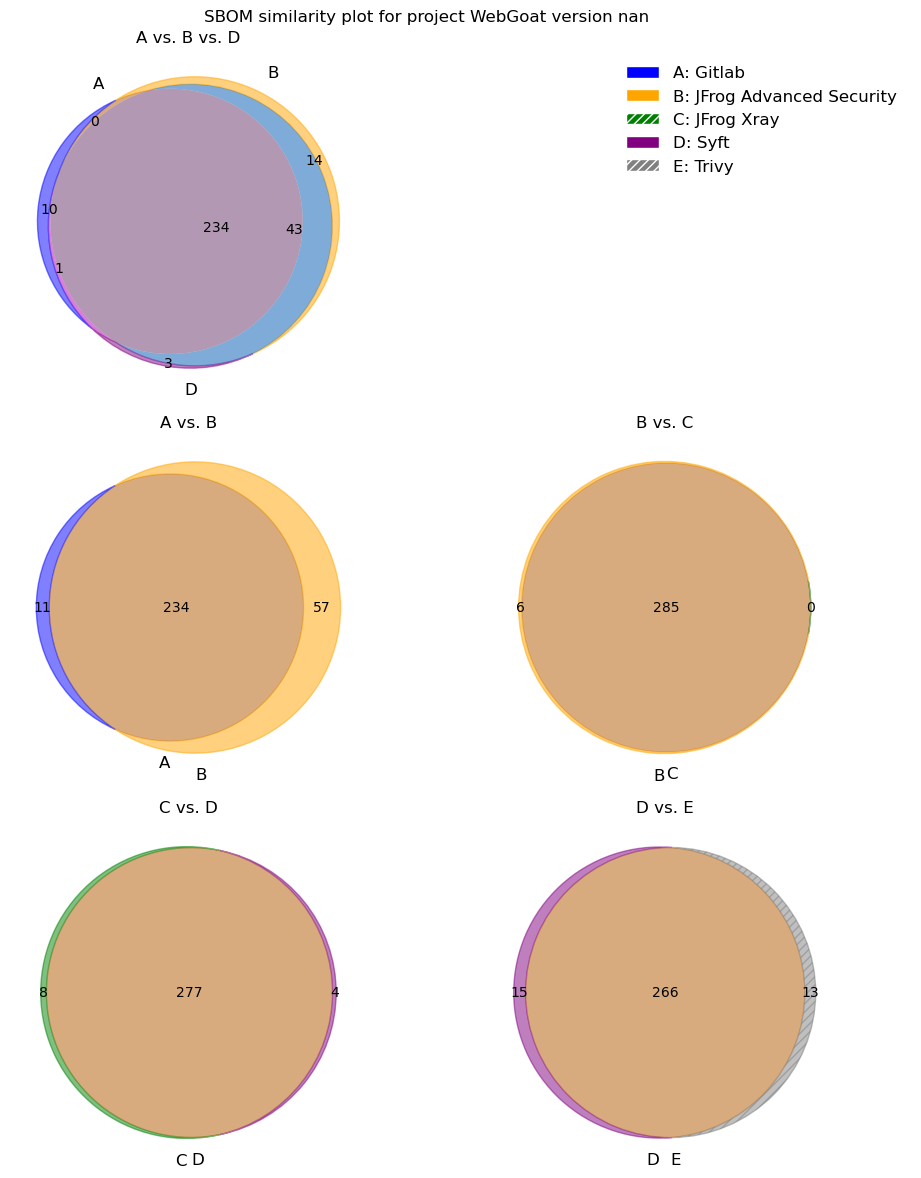

Evaluating data for confusion matrix of project: iEdgeMicroService - None.


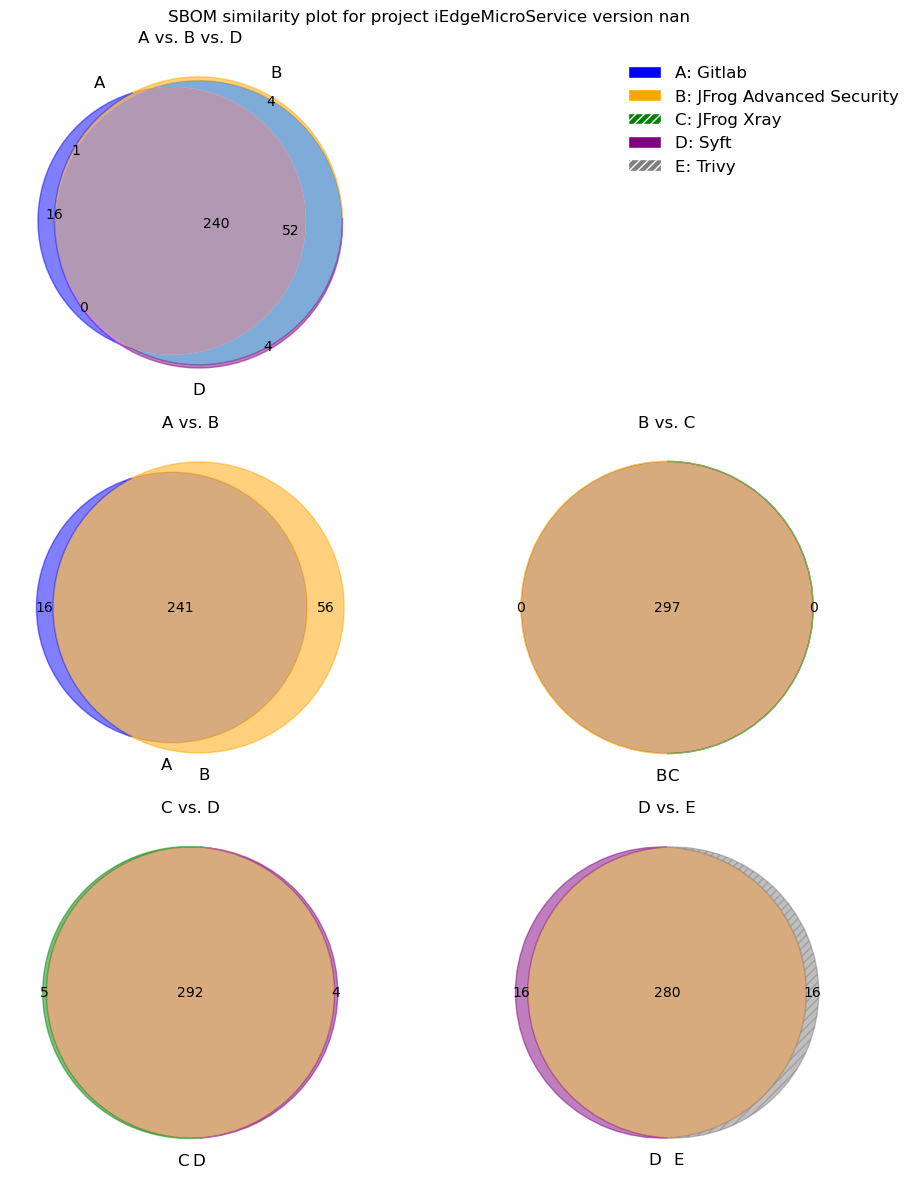

Evaluating data for confusion matrix of project: pm-dashboard-frontend - None.


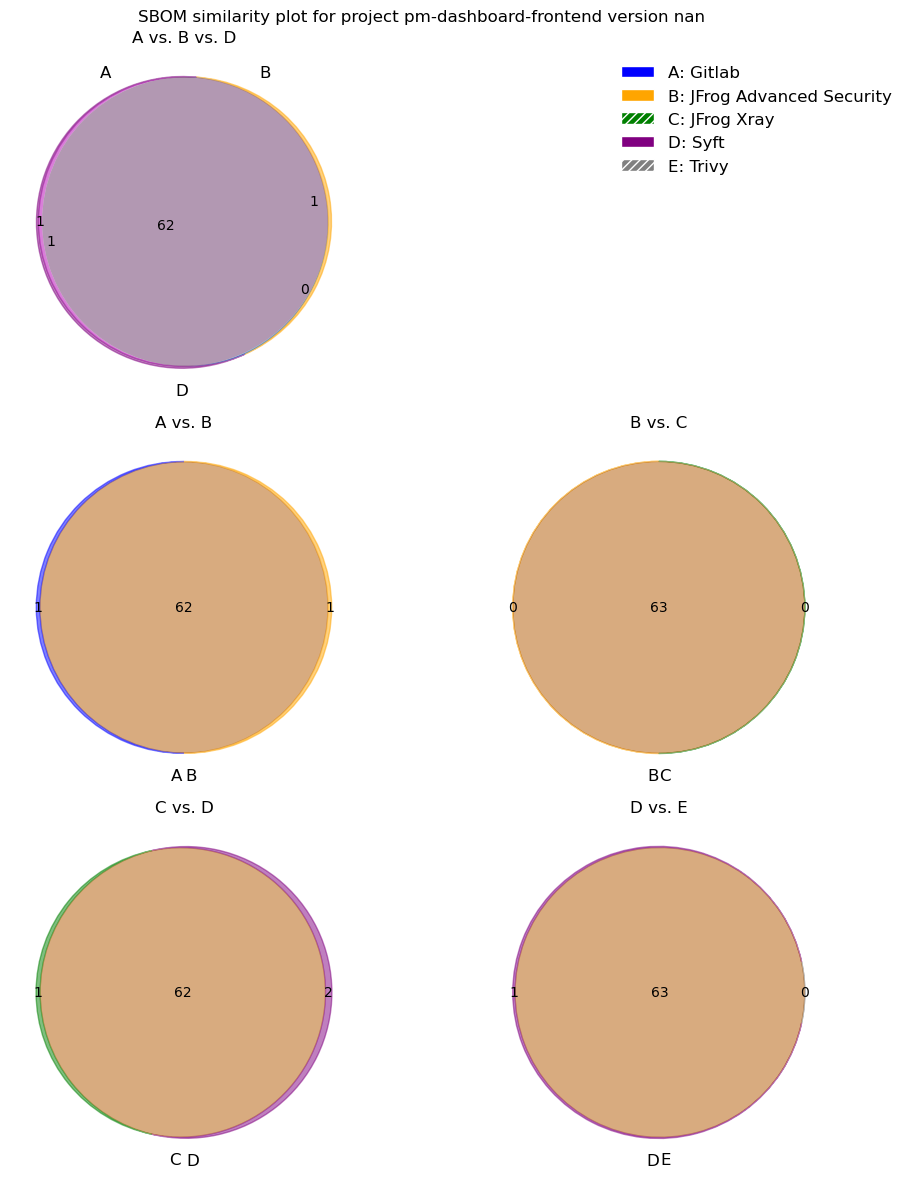

Evaluating data for confusion matrix of project: pm-lst-kpi-module - None.


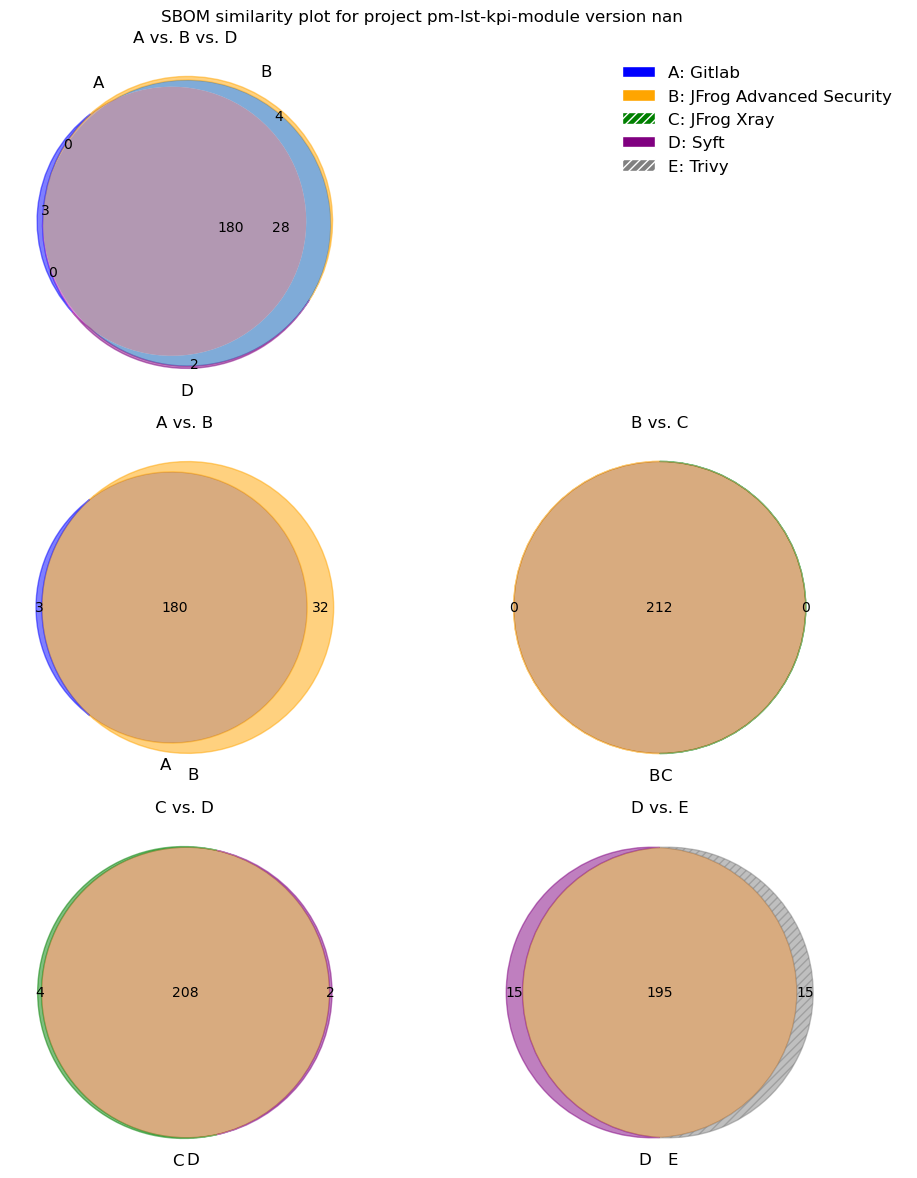

Evaluating data for confusion matrix of project: pm-mongo - None.


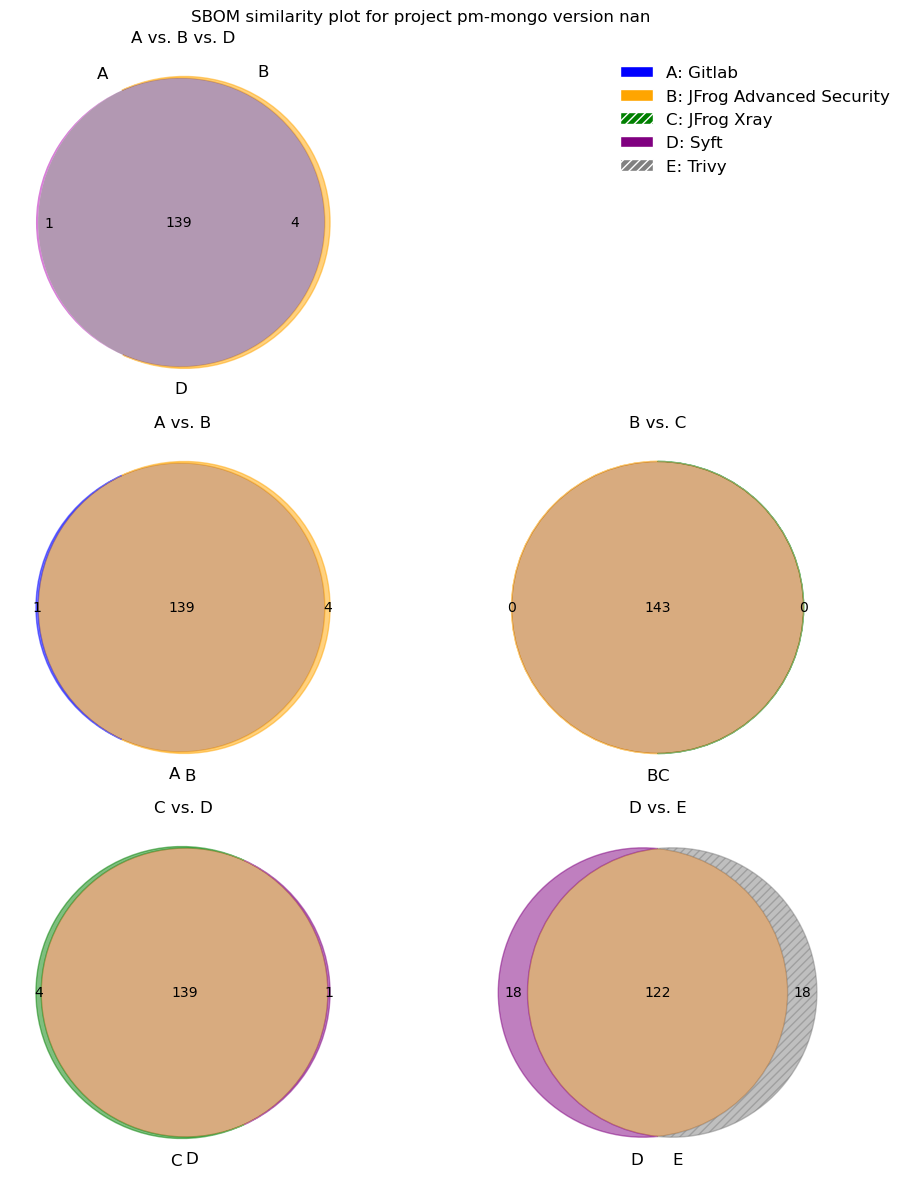

In [4]:
columns = ['project_name', 'project_version', 'scanner_name', 'name_version', 'name', 'version']
project_version_grouped = scanner_data_agg_df[columns].groupby(['project_name', 'project_version'], dropna=False)

for key, scanner_data_df in project_version_grouped:

    project_name, project_version = key  # Unpack the group key
    if pd.isna(project_version):
        project_version_str = 'None'
        target_output_file = f"SBOM_comparison_{project_name}.png"    
    else:
        project_version_str = str(project_version) 
        target_output_file = f"SBOM_comparison_{project_name}_{project_version}.png"
        
    print(f"Evaluating data for confusion matrix of project: {project_name} - {project_version_str}.")
    
    create_SBOM_similarity_plot(project_name, project_version, scanner_data_df, target_output_file)

#### Debug

In [5]:
scanner_data_agg_df.columns

Index(['scanner_name', 'name', 'version', 'purl', 'bom-ref', 'hashes',
       'hash_sum', 'hash_algo', 'p_type', 'p_namespace', 'p_name', 'p_version',
       'p_qualifiers', 'p_subpath', 'project_name', 'project_version',
       'project_name_version', 'name_version'],
      dtype='object')

### Visuailze SBOM data confusion matrix

Evaluating data for confusion matrix of project: Floodlight


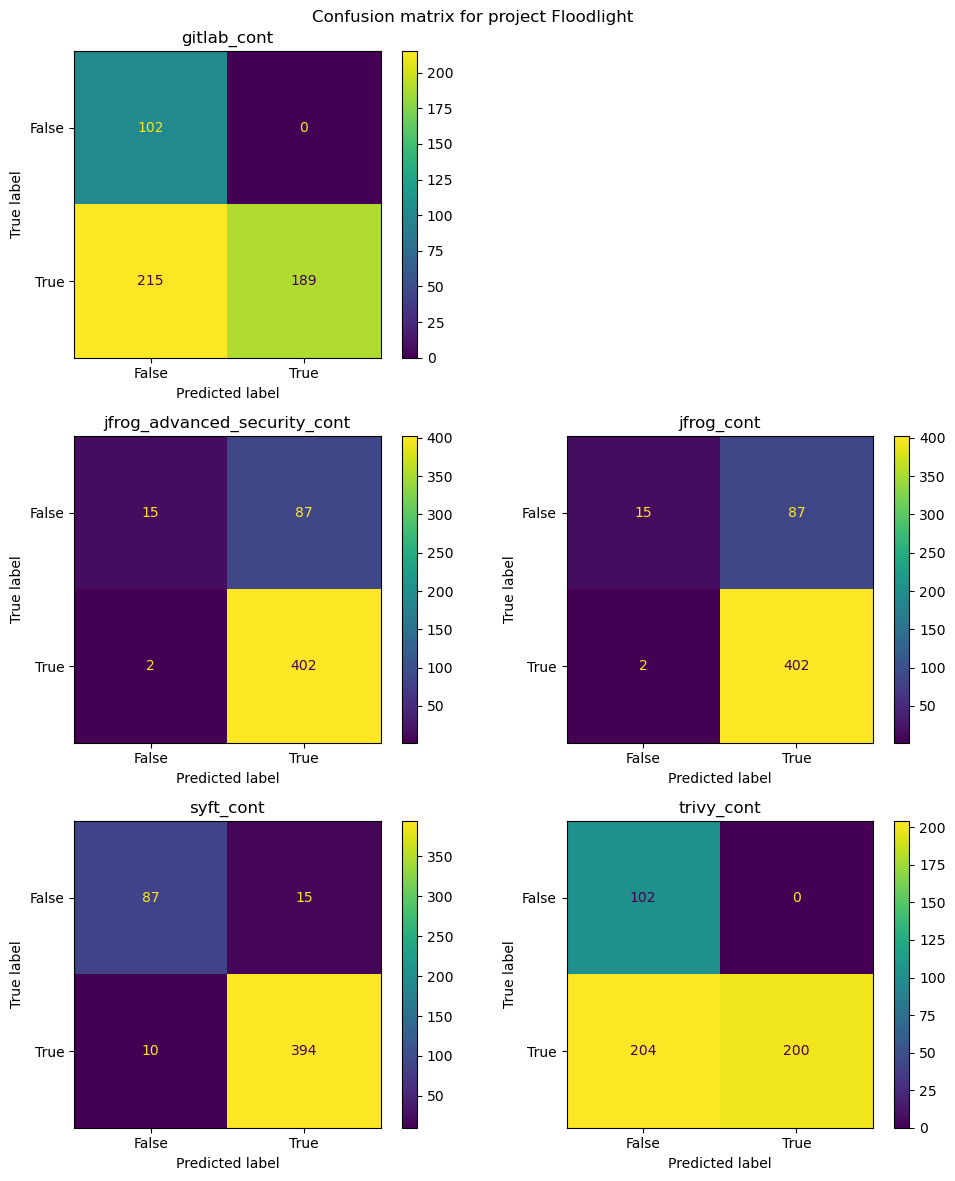

Evaluating data for confusion matrix of project: Generator_2


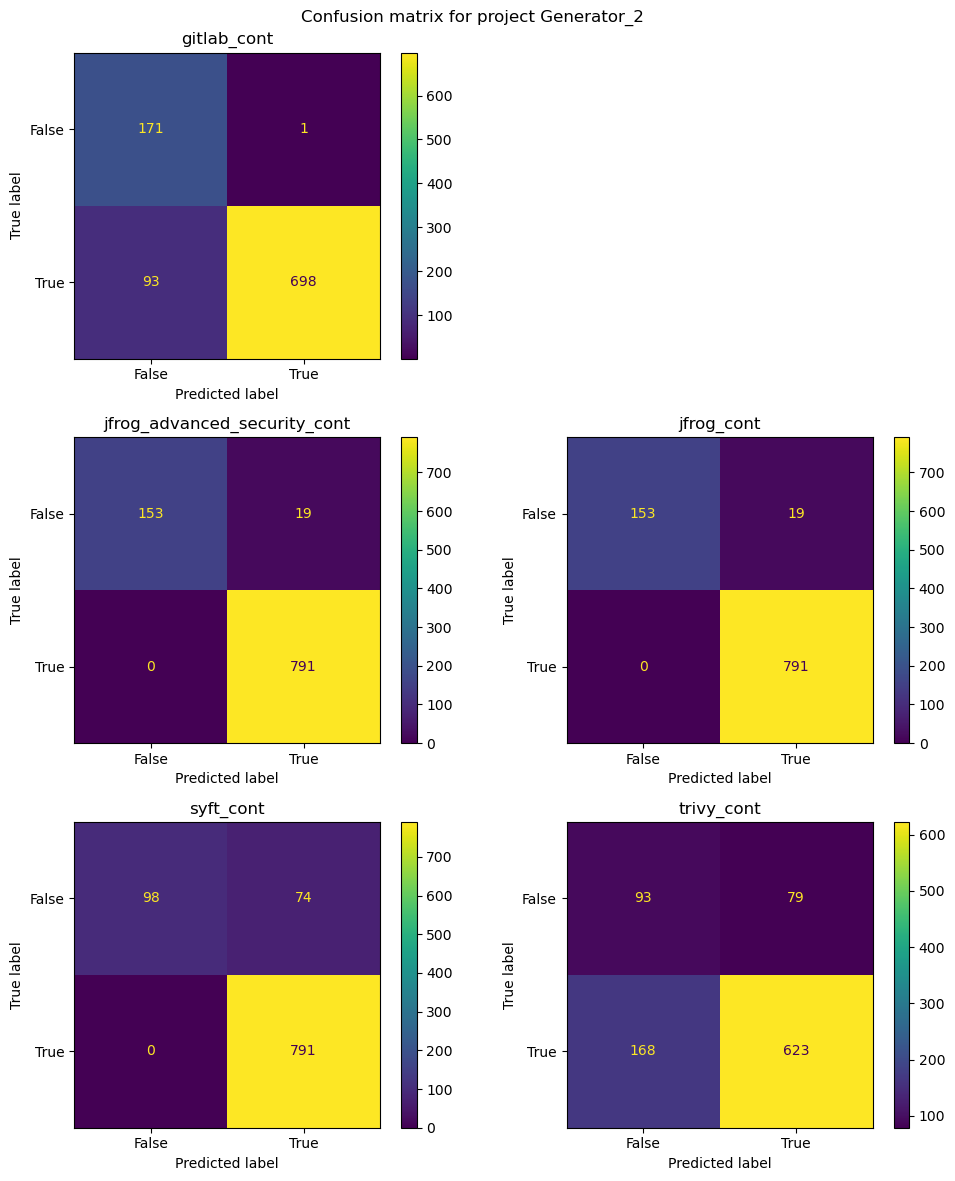

Evaluating data for confusion matrix of project: Juice_Shop


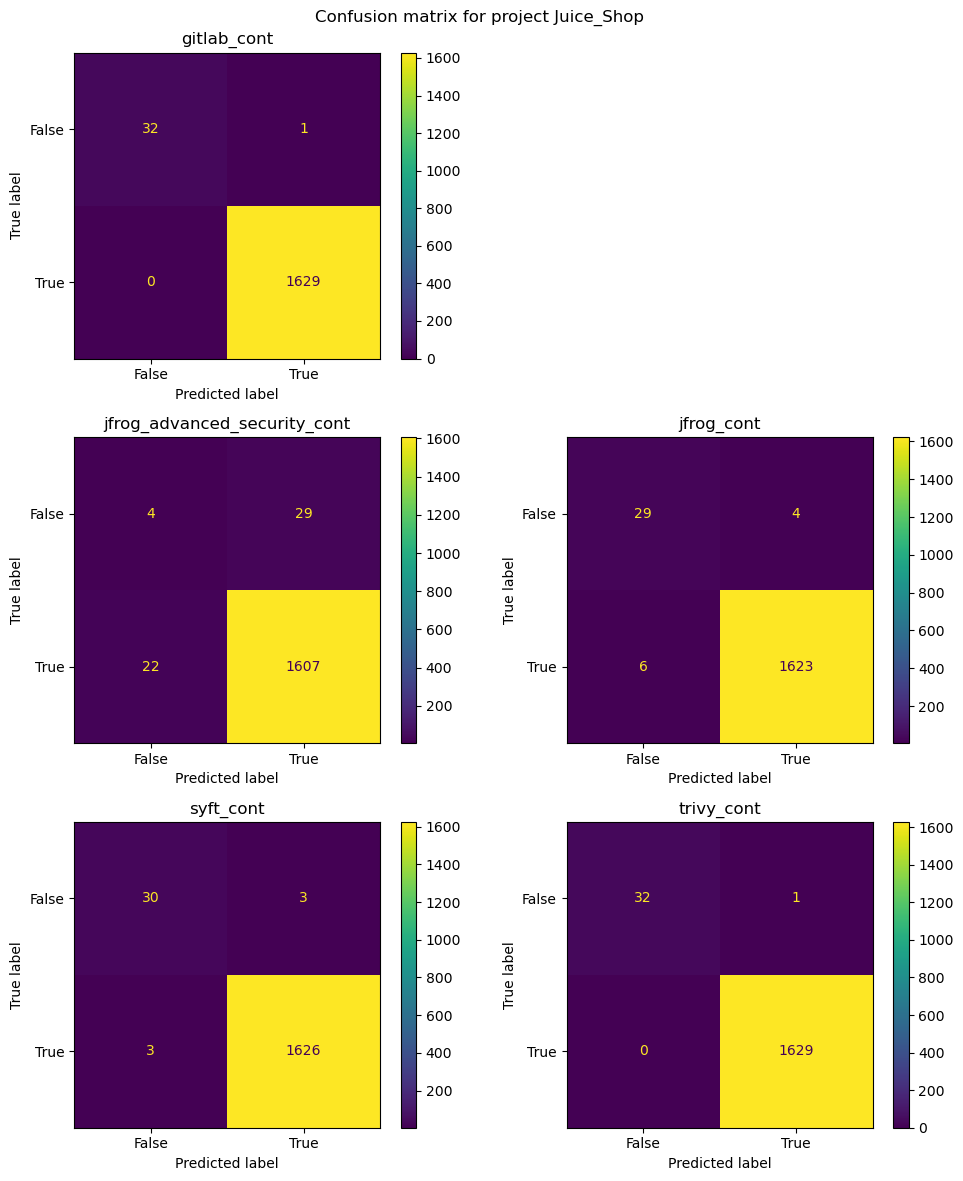

Evaluating data for confusion matrix of project: NMP


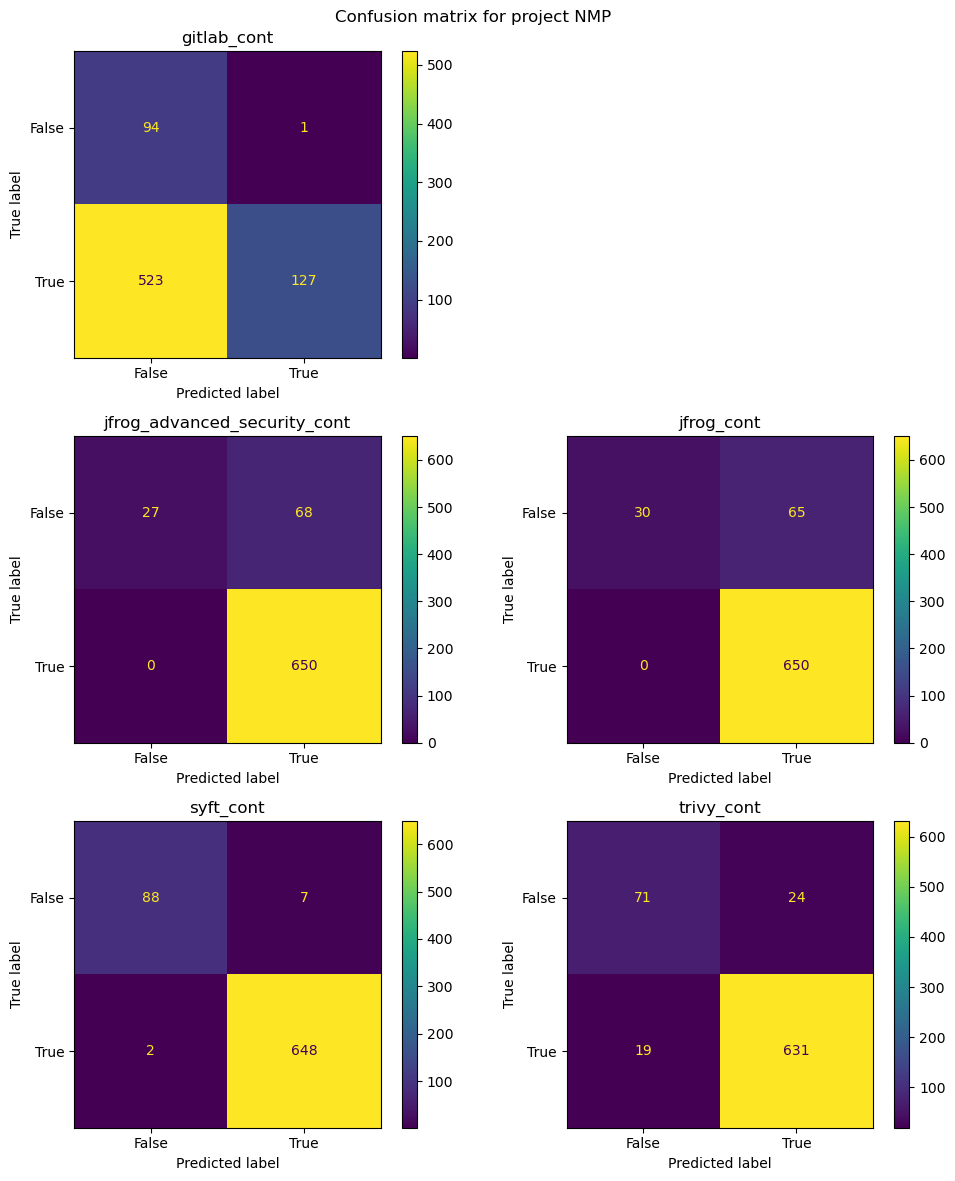

Evaluating data for confusion matrix of project: RDCS_RDCP-Client


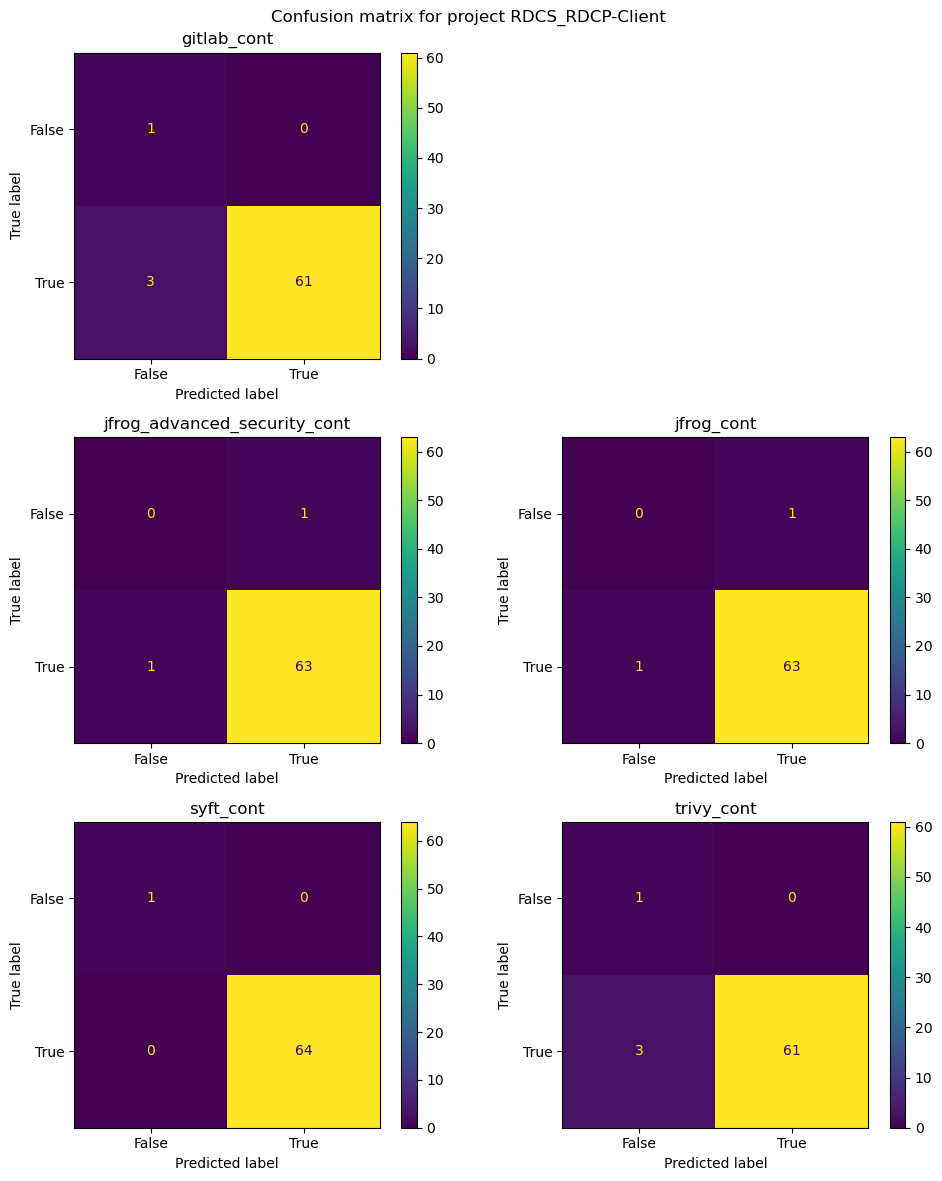

Evaluating data for confusion matrix of project: RT-Cosmo


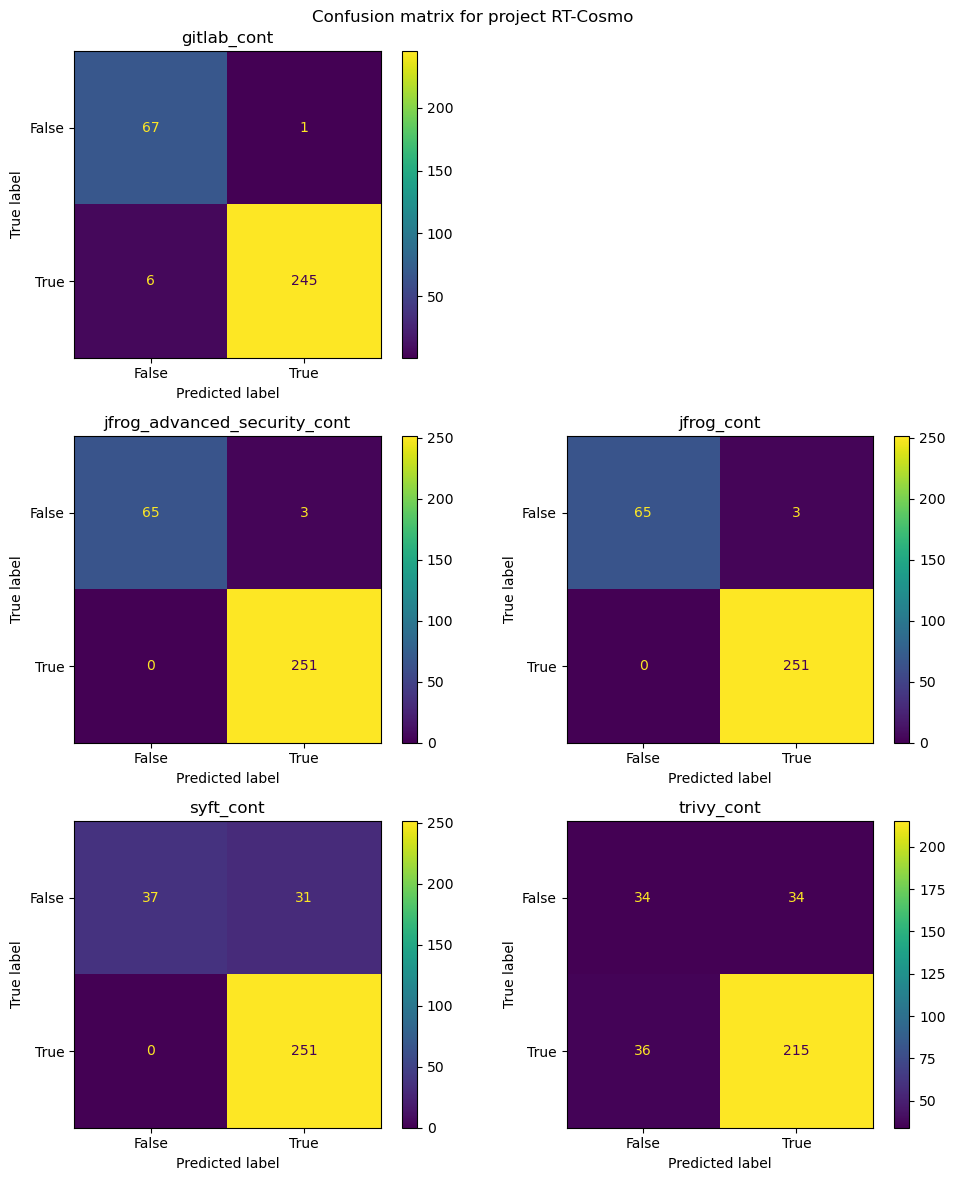

Evaluating data for confusion matrix of project: Vulnerable_Flask_App_0.2


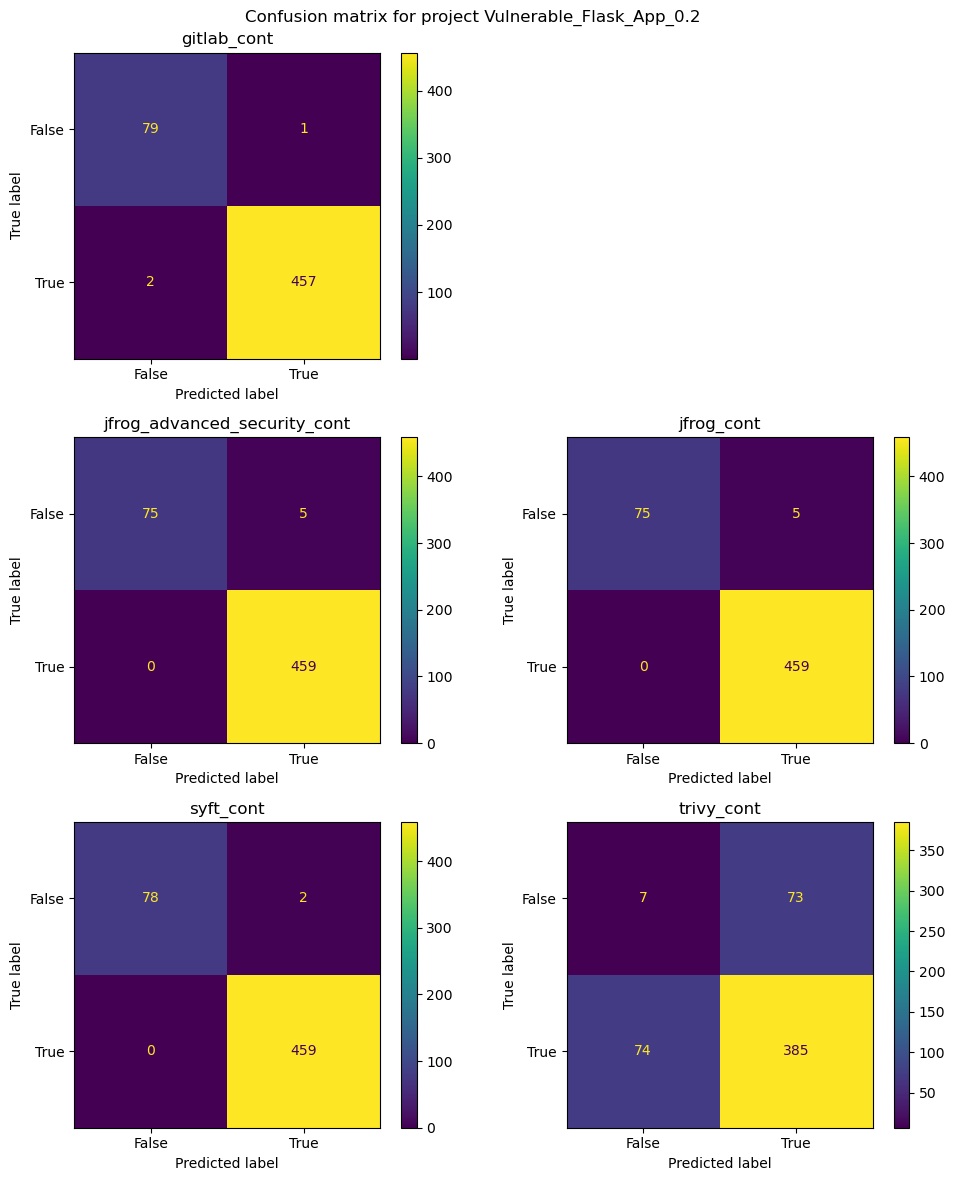

Evaluating data for confusion matrix of project: Vulnerable_Flask_App_1.2


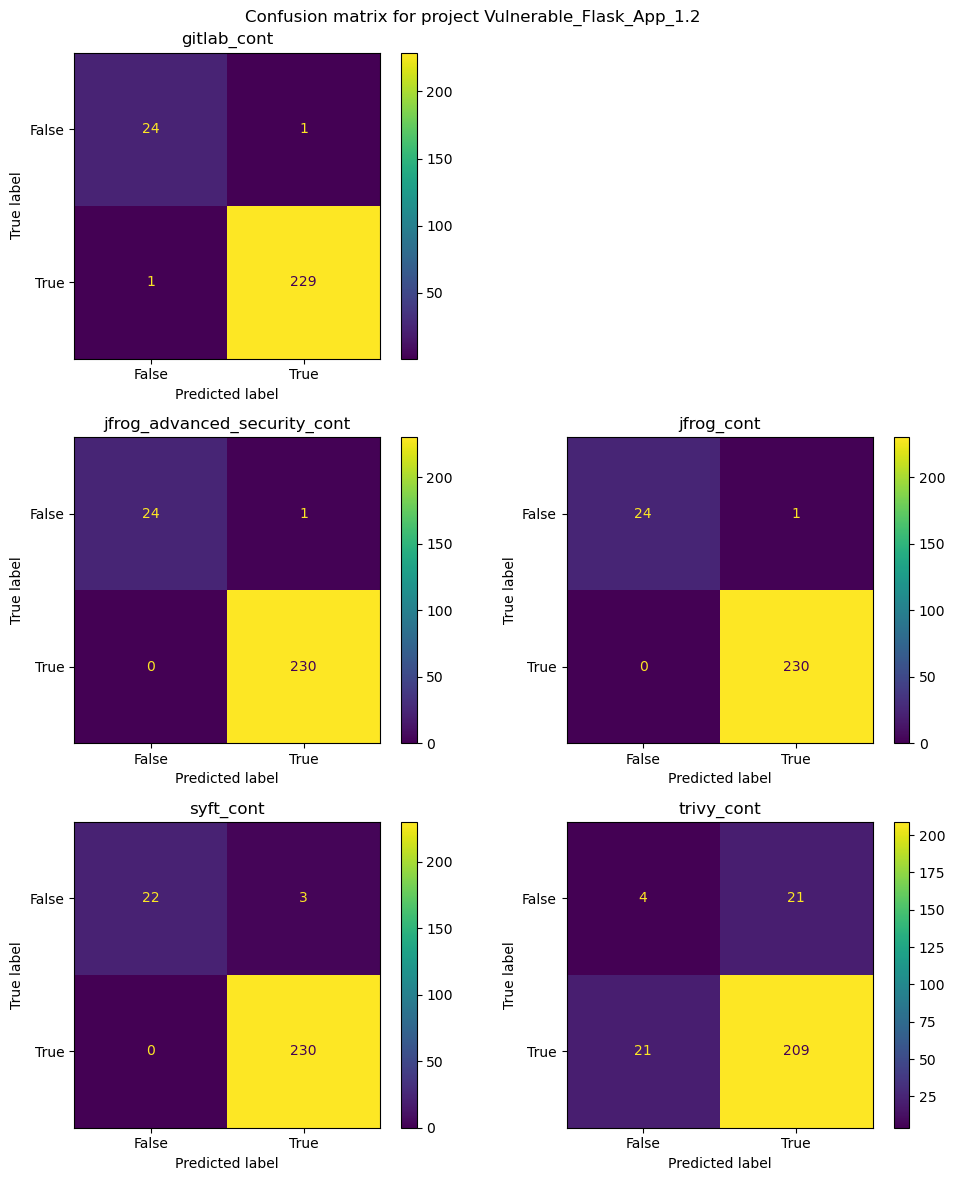

Evaluating data for confusion matrix of project: WebGoat


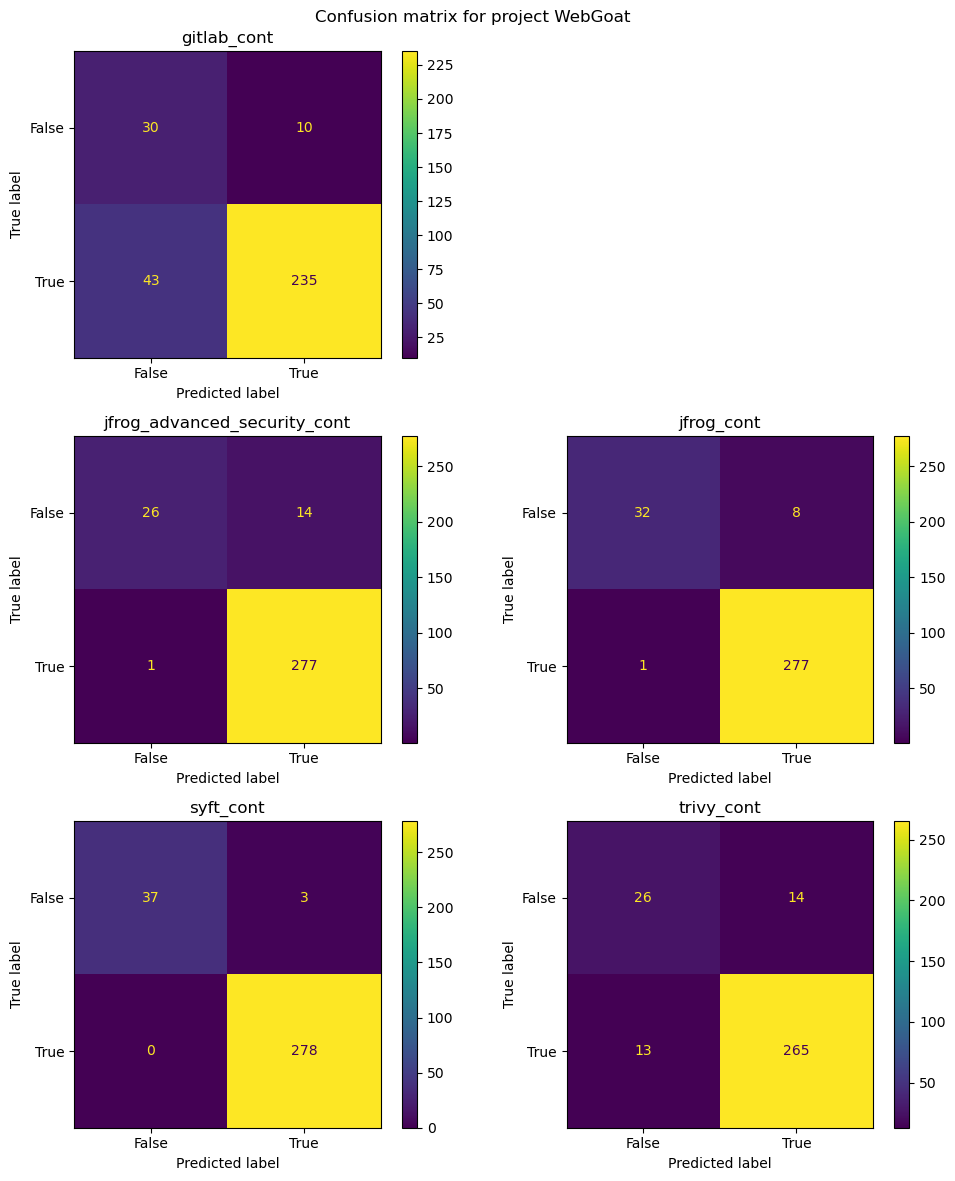

Evaluating data for confusion matrix of project: iEdgeMicroService


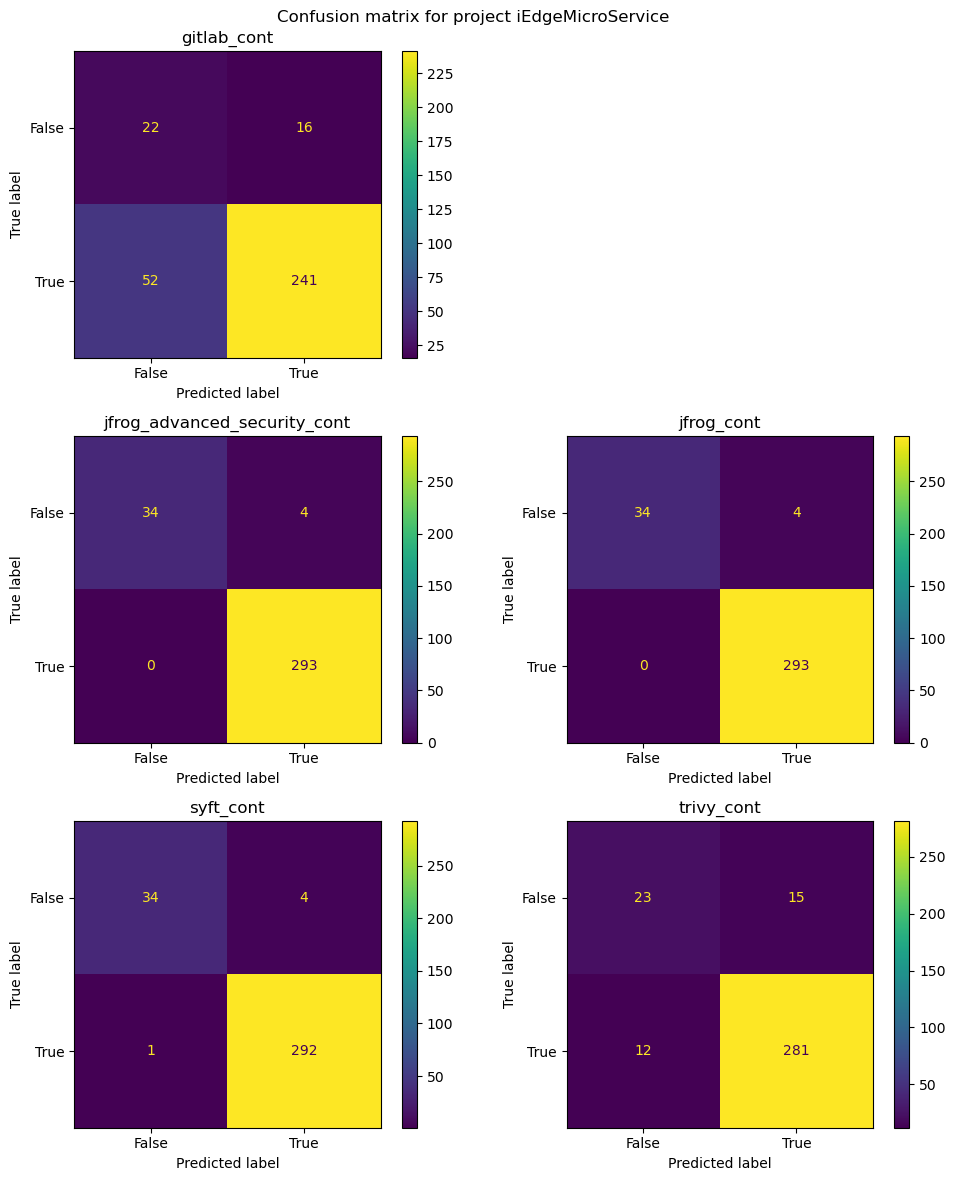

Evaluating data for confusion matrix of project: pm-dashboard-frontend


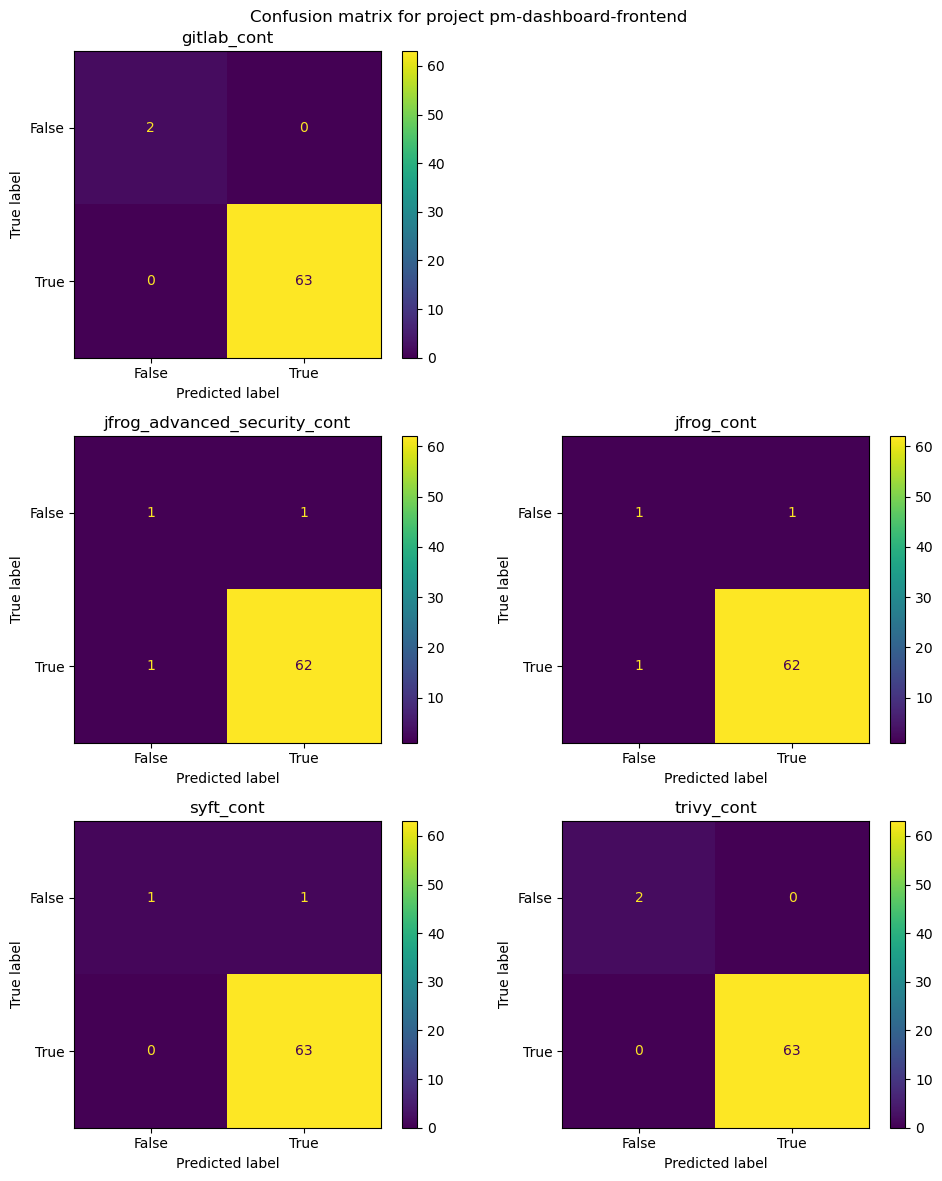

Evaluating data for confusion matrix of project: pm-lst-kpi-module


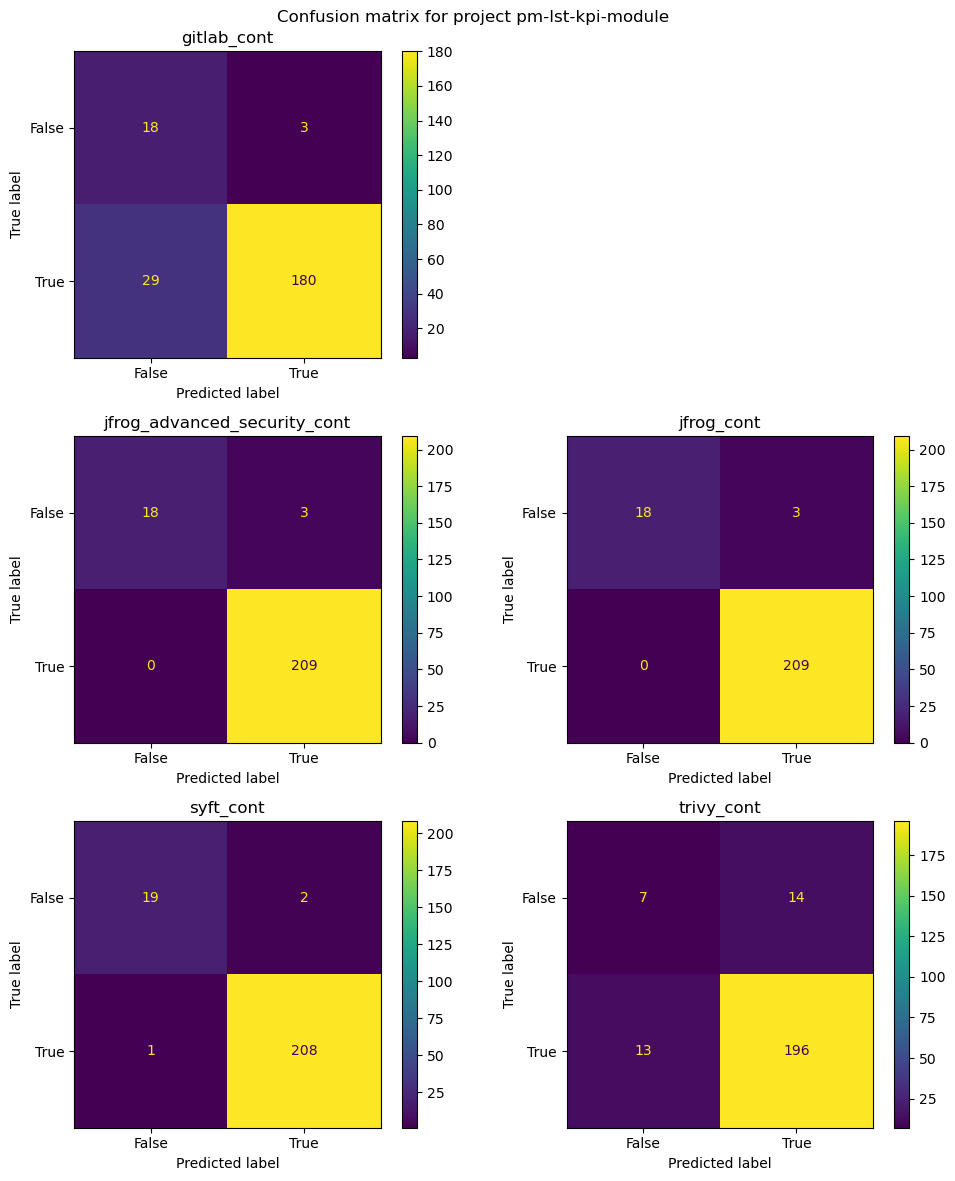

Evaluating data for confusion matrix of project: pm-mongo


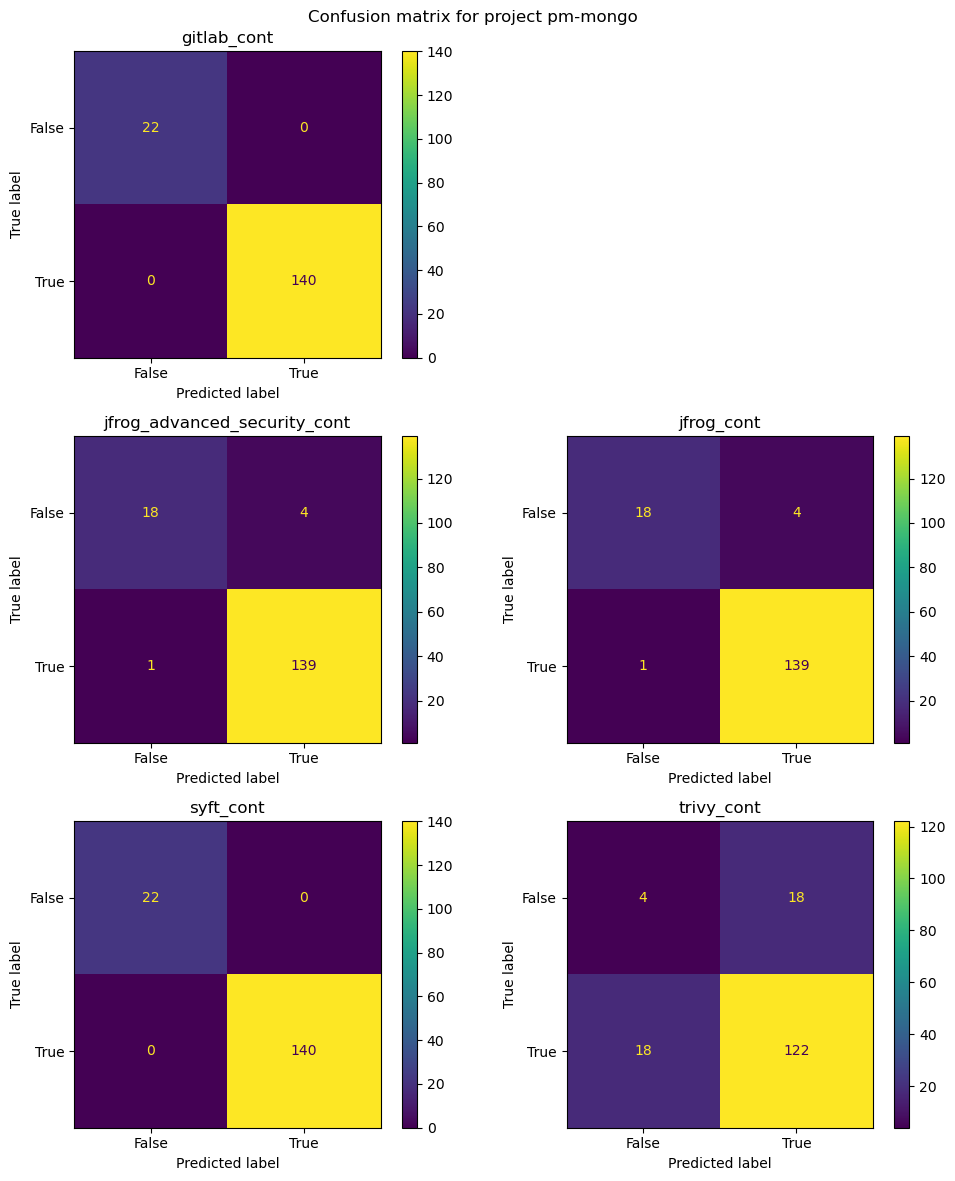

In [6]:
project_version_grouped = confusion_matrix_agg_df.groupby(['project_name_version'], dropna=False)

for project_name_version, scanner_data_df in project_version_grouped:
    
    print(f"Evaluating data for confusion matrix of project: {project_name_version[0]}")
     
    target_output_file = f"SBOM_confusion_matrix_{project_name_version[0]}.png"    
        
    # Create confusion matrix for every project
    create_SBOM_confusion_matrix(project_name_version[0], scanner_data_df, target_output_file)

#### Debug

## Data Analysis

In [5]:
scanner_data_agg_df.columns

Index(['scanner_name', 'name', 'version', 'purl', 'bom-ref', 'hashes',
       'p_type', 'p_namespace', 'p_name', 'p_version', 'p_qualifiers',
       'p_subpath', 'project_name', 'project_version', 'project_name_version',
       'name_version'],
      dtype='object')

numnber of artifacts per project per scannerames



In [11]:
df = scanner_data_agg_df
df ['p_type'].unique()

array([None, 'apk', 'maven', 'alpine', 'generic', 'docker', 'gem', 'deb',
       'pypi', 'rubygems', 'go', 'cpp', 'npm', 'composer', 'nuget'],
      dtype=object)

In [23]:
df = scanner_data_agg_df

ind_mask = df['version'].isna()
df = df[ind_mask]

df[df['scanner_name'] == 'jfrog_advanced_security_cont']['name']


252                    agent-bridge-datastore.jar
253                              agent-bridge.jar
254                              akka-2.2-1.0.jar
255                  akka-http-2.11_2.4.5-1.0.jar
256                 akka-http-2.13_10.1.8-1.0.jar
                           ...                   
25922                     jruby_cache_backend.jar
25923                  mavenEcjBootstrapAgent.jar
26007                                  parser.jar
26009                                   psych.jar
26014    spring-boot-jarmode-layertools-2.7.1.jar
Name: name, Length: 489, dtype: object

In [7]:
df = scanner_data_agg_df
ind_mask = df['version'].isna()
df = df[ind_mask]

df = df.groupby(['project_name_version', 'scanner_name'])['version'].size()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_artifacts_with_no_version_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,jfrog_advanced_security_cont,jfrog_cont,syft_cont
project_name_version,,,
Floodlight,24.0,24.0,12.0
Generator_2,18.0,18.0,10.0
Juice_Shop,6.0,6.0,NaN
NMP,3.0,3.0,NaN
RT-Cosmo,29.0,9.0,2.0
Vulnerable_Flask_App_0.2,3.0,3.0,NaN
WebGoat,10.0,10.0,9.0
iEdgeMicroService,1.0,1.0,NaN
pm-lst-kpi-module,3.0,3.0,2.0


In [8]:
df = scanner_data_agg_df
ind_mask = df['version'].isna()
df = df[ind_mask]

grouped = df.groupby('purl').agg({'project_name_version': 'unique', 'scanner_name': 'unique'})

target_file = '../output/SBOM/Files_without_version_number.csv'
grouped.to_csv(target_file)

#### 1. Number of unique artifacts with version per project and scanner

In [13]:
df = scanner_data_agg_df
ind_mask = df['version'].notna()
df = df[ind_mask]


df = df.groupby(['project_name_version', 'scanner_name'])['name_version'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_artifacts_with_name_and_version_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,189,191,191,409,200
Generator_2,699,783,783,865,702
Juice_Shop,1630,1636,1627,1629,1630
NMP,128,658,655,655,655
RDCS_RDCP-Client,61,64,64,64,61
RT-Cosmo,246,248,248,282,249
Vulnerable_Flask_App_0.2,458,464,464,461,458
Vulnerable_Flask_App_1.2,230,231,231,233,230
WebGoat,245,290,284,281,279


#### 2. Number of purls (unique) purls per project and scanner

In [27]:
df = scanner_data_agg_df.groupby(['project_name_version', 'scanner_name'])['purl'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_artifacts_with_purl_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,188,386,0,419,199
Generator_2,698,783,0,874,701
Juice_Shop,1629,1642,1633,1628,1629
NMP,127,184,181,654,655
RDCS_RDCP-Client,60,64,64,63,60
RT-Cosmo,245,344,0,283,248
Vulnerable_Flask_App_0.2,457,465,465,460,457
Vulnerable_Flask_App_1.2,229,231,231,232,229
WebGoat,245,163,157,289,278


#### 3. Number of unique hashes per project and scanner

In [28]:
df = scanner_data_agg_df
df = df.groupby(['project_name_version', 'scanner_name'])['hash_sum'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_artifacts_with_hash_per_project_and_scanner.csv'
df.to_csv(target_file)
df


scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,0,389,389,0,63
Generator_2,0,804,804,0,0
Juice_Shop,0,54,14,0,0
NMP,0,522,521,0,0
RDCS_RDCP-Client,0,64,64,0,60
RT-Cosmo,0,362,353,0,0
Vulnerable_Flask_App_0.2,0,442,442,0,0
Vulnerable_Flask_App_1.2,0,195,195,0,0
WebGoat,0,298,294,0,0


#### 4. Numnber of artifacts with no version field

In [29]:
df = scanner_data_agg_df
df = df.groupby(['project_name_version', 'scanner_name'])['version'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_artifacts_with_version_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,123,274,274,276,125
Generator_2,449,508,508,524,450
Juice_Shop,521,517,521,523,521
NMP,91,279,279,279,280
RDCS_RDCP-Client,53,55,55,55,53
RT-Cosmo,161,167,167,181,160
Vulnerable_Flask_App_0.2,231,237,237,234,228
Vulnerable_Flask_App_1.2,142,143,143,145,140
WebGoat,168,189,186,183,180


#### 5. Number of p_types detected

In [23]:
df = scanner_data_agg_df

df = df.groupby(['project_name_version', 'scanner_name'])['p_type'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_p_types_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,2,3,0,3,2
Generator_2,4,7,0,5,4
Juice_Shop,2,6,5,5,3
NMP,2,4,3,2,2
RDCS_RDCP-Client,1,2,2,1,1
RT-Cosmo,2,6,0,3,3
Vulnerable_Flask_App_0.2,2,5,5,3,2
Vulnerable_Flask_App_1.2,2,3,3,4,2
WebGoat,2,5,4,3,2


#### 6. Number of p_namespaces detected

'purl', 'bom-ref', 'hashes', 'p_type', 'p_namespace', 'p_name', 'p_version', 'p_qualifiers', 'p_subpath'url

In [40]:
df = scanner_data_agg_df

df = df.groupby(['project_name_version', 'scanner_name'])['p_namespace'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_p_namespaces_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,49,0,0,305,58
Generator_2,2,0,0,54,5
Juice_Shop,34,0,0,34,34
NMP,10,0,0,229,184
RDCS_RDCP-Client,1,0,0,1,1
RT-Cosmo,1,0,0,10,4
Vulnerable_Flask_App_0.2,1,0,0,1,1
Vulnerable_Flask_App_1.2,1,0,0,1,1
WebGoat,70,0,0,119,81


#### 7. Number of 'p_qualifiers' detected

In [41]:
df = scanner_data_agg_df
df['p_qualifiers_tag'] = df['p_qualifiers'].apply(lambda x: ', '.join([f'{key}:{value}' for key, value in x.items()]) if x else None)
df

df = df.groupby(['project_name_version', 'scanner_name'])['p_qualifiers_tag'].nunique()
df = df.unstack()

target_file = '../output/SBOM/SBOM_data_number_of_unique_p_qualifiers_per_project_and_scanner.csv'
df.to_csv(target_file)
df

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,1,0,0,20,1
Generator_2,1,0,0,319,9
Juice_Shop,1,0,0,5,2
NMP,1,0,0,64,5
RDCS_RDCP-Client,1,0,0,19,1
RT-Cosmo,1,0,0,109,7
Vulnerable_Flask_App_0.2,1,0,0,183,9
Vulnerable_Flask_App_1.2,1,0,0,83,6
WebGoat,1,0,0,69,5


### Metrics from confusion matrix

#### Base metrics
- number of unique samples
- number of unflaged samples (samples not found by respective scanner)
- number of flaged samples (samples identified by respective scanner)
- number of samples labeled negative (samples that are labeled as negatives)
- number of samples labeled positive (samples that ar labeled as positives)
- number of samples with 1 vote
- number of samples with 2 vote
- number of samples with 3 vote
- number of samples with 4 vote
- number of samples with 5 vote

In [7]:
df = confusion_matrix_agg_df

result = df.groupby(['project_name_version', 'scanner_name']).agg(
    flag_count=('flag', 'count'),
    flag_0_count=('flag', lambda x: (x == 0).sum()),
    flag_1_count=('flag', lambda x: (x == 1).sum()),
    label_0_count=('label', lambda x: (x == 0).sum()),
    label_1_count=('label', lambda x: (x == 1).sum()),
    vote_1_count=('vote', lambda x: (x == 1).sum()),
    vote_2_count=('vote', lambda x: (x == 2).sum()),
    vote_3_count=('vote', lambda x: (x == 3).sum()),
    vote_4_count=('vote', lambda x: (x == 4).sum()),
    vote_5_count=('vote', lambda x: (x == 5).sum())
).reset_index()
result

,project_name_version,scanner_name,flag_count,flag_0_count,flag_1_count,label_0_count,label_1_count,vote_1_count,vote_2_count,vote_3_count,vote_4_count,vote_5_count
0,Floodlight,gitlab_cont,506,317,189,102,404,15,87,216,1,187
1,Floodlight,jfrog_advanced_security_cont,506,17,489,102,404,15,87,216,1,187
2,Floodlight,jfrog_cont,506,17,489,102,404,15,87,216,1,187
3,Floodlight,syft_cont,506,97,409,102,404,15,87,216,1,187
4,Floodlight,trivy_cont,506,306,200,102,404,15,87,216,1,187
...,...,...,...,...,...,...,...,...,...,...,...,...
60,pm-mongo,gitlab_cont,162,22,140,22,140,18,4,1,18,121
61,pm-mongo,jfrog_advanced_security_cont,162,19,143,22,140,18,4,1,18,121
62,pm-mongo,jfrog_cont,162,19,143,22,140,18,4,1,18,121
63,pm-mongo,syft_cont,162,22,140,22,140,18,4,1,18,121


#### Target metrics

- detection accuracy
- false positive rate
- true positive rate

In [9]:
def assign_result(row):
    if row['label'] == 1 and row['flag'] == 1:
        return 'TP'
    elif row['label'] == 0 and row['flag'] == 1:
        return 'FP'
    elif row['label'] == 1 and row['flag'] == 0:
        return 'FN'
    elif row['label'] == 0 and row['flag'] == 0:
        return 'TN'
    else:
        return 'Unknown'

def detection_accuracy(row):
    return ((row['TP_count'] + row['TN_count'])/
            (row['TP_count'] + row['TN_count'] + row['FP_count'] + row['FN_count']))

def false_positive_rate(row):
   return ((row['FP_count'])/
            (row['FP_count'] + row['TN_count']))

def true_positive_rate(row):
    return ((row['TP_count'])/
            (row['TP_count'] + row['FN_count']))

df = confusion_matrix_agg_df.copy()

# Apply the custom function to create the "result" column
df['result'] = df.apply(assign_result, axis=1)


result = df.groupby(['project_name_version', 'scanner_name']).agg(
    flag_count=('flag', 'count'),
    flag_0_count=('flag', lambda x: (x == 0).sum()),
    flag_1_count=('flag', lambda x: (x == 1).sum()),
    label_0_count=('label', lambda x: (x == 0).sum()),
    label_1_count=('label', lambda x: (x == 1).sum()),
    vote_1_count=('vote', lambda x: (x == 1).sum()),
    vote_2_count=('vote', lambda x: (x == 2).sum()),
    vote_3_count=('vote', lambda x: (x == 3).sum()),
    vote_4_count=('vote', lambda x: (x == 4).sum()),
    vote_5_count=('vote', lambda x: (x == 5).sum()),
    TP_count = ('result', lambda x: (x == 'TP').sum()),
    FP_count = ('result', lambda x: (x == 'FP').sum()),
    FN_count = ('result', lambda x: (x == 'FN').sum()),
    TN_count = ('result', lambda x: (x == 'TN').sum()))


result['Detection_Accuracy'] = result.apply(detection_accuracy, axis=1)
result['FPR'] = result.apply(false_positive_rate, axis=1)
result['TPR'] = result.apply(true_positive_rate, axis=1)
result = result.reset_index()

target_file = target_file = '../output/SBOM/SBOM_metrics_per_project_and_scanner.csv'
result.to_csv(target_file)

In [62]:
(402)/(402+2)

0.995049504950495

##### Detection Accuracy

In [14]:
pivot_table = result.pivot_table(index='project_name_version', columns='scanner_name', values='Detection_Accuracy')

target_file = target_file = '../output/SBOM/SBOM_detection_accuracy.csv'
pivot_table.to_csv(target_file)
pivot_table

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,0.575099,0.824111,0.824111,0.950593,0.596838
Generator_2,0.902388,0.980270,0.980270,0.923157,0.743510
Juice_Shop,0.999398,0.969314,0.993983,0.996390,0.999398
NMP,0.296644,0.908725,0.912752,0.987919,0.942282
RDCS_RDCP-Client,0.953846,0.969231,0.969231,1.000000,0.953846
RT-Cosmo,0.978056,0.990596,0.990596,0.902821,0.780564
Vulnerable_Flask_App_0.2,0.994434,0.990724,0.990724,0.996289,0.727273
Vulnerable_Flask_App_1.2,0.992157,0.996078,0.996078,0.988235,0.835294
WebGoat,0.833333,0.952830,0.971698,0.990566,0.915094


#### False Positive Rate (FPR)¶

In [15]:
pivot_table = result.pivot_table(index='project_name_version', columns='scanner_name', values='FPR')

target_file = target_file = '../output/SBOM/SBOM_false_positive_rate.csv'
pivot_table.to_csv(target_file)
pivot_table

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,0.000000,0.852941,0.852941,0.147059,0.000000
Generator_2,0.005814,0.110465,0.110465,0.430233,0.459302
Juice_Shop,0.030303,0.878788,0.121212,0.090909,0.030303
NMP,0.010526,0.715789,0.684211,0.073684,0.252632
RDCS_RDCP-Client,0.000000,1.000000,1.000000,0.000000,0.000000
RT-Cosmo,0.014706,0.044118,0.044118,0.455882,0.500000
Vulnerable_Flask_App_0.2,0.012500,0.062500,0.062500,0.025000,0.912500
Vulnerable_Flask_App_1.2,0.040000,0.040000,0.040000,0.120000,0.840000
WebGoat,0.250000,0.350000,0.200000,0.075000,0.350000


#### True Positive Rate (TPR)¶

In [16]:
pivot_table = result.pivot_table(index='project_name_version', columns='scanner_name', values='TPR')

target_file = target_file = '../output/SBOM/SBOM_true_positive_rate.csv'
pivot_table.to_csv(target_file)
pivot_table

scanner_name,gitlab_cont,jfrog_advanced_security_cont,jfrog_cont,syft_cont,trivy_cont
project_name_version,,,,,
Floodlight,0.467822,0.995050,0.995050,0.975248,0.495050
Generator_2,0.882427,1.000000,1.000000,1.000000,0.787611
Juice_Shop,1.000000,0.986495,0.996317,0.998158,1.000000
NMP,0.195385,1.000000,1.000000,0.996923,0.970769
RDCS_RDCP-Client,0.953125,0.984375,0.984375,1.000000,0.953125
RT-Cosmo,0.976096,1.000000,1.000000,1.000000,0.856574
Vulnerable_Flask_App_0.2,0.995643,1.000000,1.000000,1.000000,0.838780
Vulnerable_Flask_App_1.2,0.995652,1.000000,1.000000,1.000000,0.908696
WebGoat,0.845324,0.996403,0.996403,1.000000,0.953237


In [12]:
result

,project_name_version,scanner_name,flag_count,flag_0_count,flag_1_count,label_0_count,label_1_count,vote_1_count,vote_2_count,vote_3_count,vote_4_count,vote_5_count,TP_count,FP_count,FN_count,TN_count,Detection_Accuracy,FPR,TPR
0,Floodlight,gitlab_cont,506,317,189,102,404,15,87,216,1,187,189,0,215,102,0.575099,0.000000,0.467822
1,Floodlight,jfrog_advanced_security_cont,506,17,489,102,404,15,87,216,1,187,402,87,2,15,0.824111,0.852941,0.995050
2,Floodlight,jfrog_cont,506,17,489,102,404,15,87,216,1,187,402,87,2,15,0.824111,0.852941,0.995050
3,Floodlight,syft_cont,506,97,409,102,404,15,87,216,1,187,394,15,10,87,0.950593,0.147059,0.975248
4,Floodlight,trivy_cont,506,306,200,102,404,15,87,216,1,187,200,0,204,102,0.596838,0.000000,0.495050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,pm-mongo,gitlab_cont,162,22,140,22,140,18,4,1,18,121,140,0,0,22,1.000000,0.000000,1.000000
61,pm-mongo,jfrog_advanced_security_cont,162,19,143,22,140,18,4,1,18,121,139,4,1,18,0.969136,0.181818,0.992857
62,pm-mongo,jfrog_cont,162,19,143,22,140,18,4,1,18,121,139,4,1,18,0.969136,0.181818,0.992857
63,pm-mongo,syft_cont,162,22,140,22,140,18,4,1,18,121,140,0,0,22,1.000000,0.000000,1.000000


In [ ]:
r

In [18]:
tar
confusion_matrix_agg_df

,project_name_version,scanner_name,name_version,flag,label,vote
0,Floodlight,gitlab_cont,jdbc-mysql:8.0.11-1.0,0,1,3
1,Floodlight,jfrog_advanced_security_cont,jdbc-mysql:8.0.11-1.0,1,1,3
2,Floodlight,jfrog_cont,jdbc-mysql:8.0.11-1.0,1,1,3
3,Floodlight,syft_cont,jdbc-mysql:8.0.11-1.0,1,1,3
4,Floodlight,trivy_cont,jdbc-mysql:8.0.11-1.0,0,1,3
...,...,...,...,...,...,...
30795,pm-mongo,gitlab_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,1,4
30796,pm-mongo,jfrog_advanced_security_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,1,4
30797,pm-mongo,jfrog_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,1,4
30798,pm-mongo,syft_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,1,4


In [11]:
scanner_data_agg_df['scanner_name'].unique()

array(['gitlab_cont', 'jfrog_advanced_security_cont', 'jfrog_cont',
       'syft_cont', 'trivy_cont'], dtype=object)

### Filter by project_version, scanner, label and flag

In [12]:
# 'Floodlight', 'Generator_2', 'iEdgeMicroService', 'Juice_Shop', 'NMP', 'pm-dashboard-frontend', 'pm-lst-kpi-module', 'pm-mongo',
# 'RDCS_RDCP-Client', 'RT-Cosmo', 'Vulnerable_Flask_App_0.2', 'Vulnerable_Flask_App_1.2', 'WebGoat'

# scanner_name:
# 'gitlab_cont', 'jfrog_advanced_security_cont', 'jfrog_cont', 'syft_cont', 'trivy_cont'

# scanner_data_agg_df
# confusion_matrix_agg_df

df = confusion_matrix_agg_df

project_name_version = 'NMP'
scanner_name = 'syft_cont'

df = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name)

df_FP1 = filter_by_flag_and_label(df, 1,  1)
df_FP1

,project_name_version,scanner_name,name_version,flag,name,version,label,vote
15669,NMP,syft_cont,micronaut-validation:2.5.13,1,micronaut-validation,2.5.13,1,4
15674,NMP,syft_cont,asm:9.1,1,asm,9.1,1,4
15679,NMP,syft_cont,aws-encryption-sdk-java:2.3.3,1,aws-encryption-sdk-java,2.3.3,1,4
15684,NMP,syft_cont,common-version:2.4.0-SNAPSHOT,1,common-version,2.4.0-SNAPSHOT,1,4
15689,NMP,syft_cont,jackson-module-jaxb-annotations:2.10.5,1,jackson-module-jaxb-annotations,2.10.5,1,4
...,...,...,...,...,...,...,...,...
19366,NMP,syft_cont,tar:1.30+dfsg-6,1,tar,1.30+dfsg-6,1,5
19371,NMP,syft_cont,tzdata:2021a-0+deb10u10,1,tzdata,2021a-0+deb10u10,1,5
19376,NMP,syft_cont,ucf:3.0038+nmu1,1,ucf,3.0038+nmu1,1,5
19381,NMP,syft_cont,util-linux:2.33.1-0.1,1,util-linux,2.33.1-0.1,1,5


In [29]:
df = confusion_matrix_agg_df

project_name_version = 'NMP'
scanner_name1 = 'syft_cont'
scanner_name2 = 'trivy_cont'
flag = 1
label = 1

#evaluate_difference(df, project_name_version, scanner_name1, scanner_name2, flag, label):

df1 = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name1)
df2 = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name2)

df1_FL = filter_by_flag_and_label(df1, flag,  label)
df2_FL = filter_by_flag_and_label(df2, flag,  label)


In [30]:
data_set = set(df1_FL['name_version']) - set(df2_FL['name_version'])

In [21]:
pd.DataFrame(set(df1_FL['name_version']) - set(df2_FL['name_version']))

,0
0,login:1:4.5-1.1
1,bsdutils:1:2.33.1-0.1
2,org.eclipse.persistence.jpa.jpql:2.7.7
3,libgmp10:2:6.1.2+dfsg-4+deb10u1
4,libaudit-common:1:2.8.4-3
5,org.eclipse.persistence.jpa:2.7.7
6,org.eclipse.persistence.asm:2.7.7
7,passwd:1:4.5-1.1
8,java-11-amazon-corretto-jdk:1:11.0.18.10-1
9,libaudit1:1:2.8.4-3


### Evaluate the difference between two scanners (for the same project, flag, and label)

In [16]:
df = confusion_matrix_agg_df

project_name_version = 'NMP'
scanner_name1 = 'syft_cont'
scanner_name2 = 'trivy_cont'
flag = 0
label = 1

df_ret_1_1 = get_difference_between_scanners(df, project_name_version, scanner_name1, scanner_name2, 1, 1)
df_ret_0_1 = get_difference_between_scanners(df, project_name_version, scanner_name1, scanner_name2, 0, 1)
df_ret_1_0 = get_difference_between_scanners(df, project_name_version, scanner_name1, scanner_name2, 1, 0)
df_ret_0_0 = get_difference_between_scanners(df, project_name_version, scanner_name1, scanner_name2, 0, 0)

In [17]:
df_ret_1_1

,artifacts
0,file-format-oncomine:2019-vcf-2.4.0-SNAPSHOT
1,jackson-module-scala_2.13:2.13.3
2,org.eclipse.persistence.antlr:2.7.7
3,passwd:1:4.5-1.1
4,java-11-amazon-corretto-jdk:1:11.0.18.10-1
5,libpcre3:2:8.39-12
6,org.eclipse.persistence.jpa:2.7.7
7,libgmp10:2:6.1.2+dfsg-4+deb10u1
8,libattr1:1:2.4.48-4
9,login:1:4.5-1.1


In [18]:
df_ret_1_0

,artifacts
0,jrt-fs:11.0.18
1,debian:10
2,kase-interpretation-portal:2.4.0-SNAPSHOT


In [19]:
df_ret_0_1

,artifacts
0,javax.inject:1
1,java-client:3.3.4


In [20]:
df_ret_0_0

,artifacts
0,libgmp10:6.1.2+dfsg-4+deb10u1
1,org.eclipse.persistence.antlr:2.7.5-RC1
2,org.eclipse.persistence.jpa:2.7.7-RC2
3,zlib1g:1.2.11.dfsg-1+deb10u2
4,libaudit-common:2.8.4-3
5,org.eclipse.persistence.asm:2.7.7-RC1
6,bsdutils:2.33.1-0.1
7,java-11-amazon-corretto-jdk:11.0.18.10-1
8,libaudit1:2.8.4-3
9,libattr1:2.4.48-4


In [ ]:
def evaluate_difference(df, project_name_version, scanner_name1, scanner_name2, flag, label):

    if not isinstance(project_name_version1, str) or not isinstance(scanner_name1, str):
        raise ValueError("'project_name_version' and 'scanner_name' must be strings")
    if not isinstance(project_name_version2, str) or not isinstance(scanner_name2, str):
        raise ValueError("'project_name_version' and 'scanner_name' must be strings")
    if not isinstance(flag1, int) or not isinstance(label1, int):
        raise ValueError("'flag' and 'label' must be integer types")
    if not isinstance(flag1, int) or not isinstance(label1, int):
        raise ValueError("'flag' and 'label' must be integer types")

    df1 = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name1)
    df2 = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name2)

    df1_FL = filter_by_flag_and_label(df1, flag,  label)
    df2_FL = filter_by_flag_and_label(df2, flag,  label)

    data_set = set(df1_FL['name_version']) - set(df2_FL['name_version'])
    # Convert the set to a list of tuples
    data_list = [(value, ) for value in data_set]

    return pd.DataFrame(data_list, columns=['artifacts'])
  

In [13]:
df = confusion_matrix_agg_df




    
df = confusion_matrix_agg_df

project_name_version = 'NMP'
scanner_name = 'syft_cont'

df = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name)

df_FP1 = filter_by_flag_and_label(df, 1,  1)
df_FP1


project_name_version = 'NMP'
scanner_name = 'trivy_cont'

df = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name)

df_FP2 = filter_by_flag_and_label(df, 1,  1)
df_FP2

,project_name_version,scanner_name,name_version,flag,name,version,label,vote
15670,NMP,trivy_cont,micronaut-validation:2.5.13,1,micronaut-validation,2.5.13,1,4
15675,NMP,trivy_cont,asm:9.1,1,asm,9.1,1,4
15680,NMP,trivy_cont,aws-encryption-sdk-java:2.3.3,1,aws-encryption-sdk-java,2.3.3,1,4
15685,NMP,trivy_cont,common-version:2.4.0-SNAPSHOT,1,common-version,2.4.0-SNAPSHOT,1,4
15690,NMP,trivy_cont,jackson-module-jaxb-annotations:2.10.5,1,jackson-module-jaxb-annotations,2.10.5,1,4
...,...,...,...,...,...,...,...,...
19362,NMP,trivy_cont,sysvinit-utils:2.93-8,1,sysvinit-utils,2.93-8,1,5
19367,NMP,trivy_cont,tar:1.30+dfsg-6,1,tar,1.30+dfsg-6,1,5
19372,NMP,trivy_cont,tzdata:2021a-0+deb10u10,1,tzdata,2021a-0+deb10u10,1,5
19377,NMP,trivy_cont,ucf:3.0038+nmu1,1,ucf,3.0038+nmu1,1,5


In [17]:




set(df_FP1['name_version']) - set(df_FP2['name_version'])

{'bsdutils:1:2.33.1-0.1',
 'diffutils:1:3.7-3',
 'file-format-oncomine:2019-vcf-2.4.0-SNAPSHOT',
 'jackson-module-scala_2.13:2.13.3',
 'java-11-amazon-corretto-jdk:1:11.0.18.10-1',
 'libattr1:1:2.4.48-4',
 'libaudit-common:1:2.8.4-3',
 'libaudit1:1:2.8.4-3',
 'libgcc1:1:8.3.0-6',
 'libgmp10:2:6.1.2+dfsg-4+deb10u1',
 'libpcre3:2:8.39-12',
 'login:1:4.5-1.1',
 'org.eclipse.persistence.antlr:2.7.7',
 'org.eclipse.persistence.asm:2.7.7',
 'org.eclipse.persistence.core:2.7.7',
 'org.eclipse.persistence.jpa.jpql:2.7.7',
 'org.eclipse.persistence.jpa:2.7.7',
 'passwd:1:4.5-1.1',
 'zlib1g:1:1.2.11.dfsg-1+deb10u2'}

In [ ]:
df = confusion_matrix_agg_df

project_name_version = 'NMP'
scanner_name = 'gitlab_cont'

df = filter_by_project_name_version_and_scanner(df, project_name_version, scanner_name)

df_FP = filter_by_flag_and_label(df, 0,  1)
df_FP

In [52]:
df = scanner_data_agg_df

project_name_version = 'Floodlight'
scanner_name = 'jfrog_advanced_security_cont'
df = get_project(df, project_name_version)

df1 = get_rows_with_string_in_column(df, 'name_version', 'weblogic')
df1[['scanner_name', 'name_version']]

,scanner_name,name_version
687,jfrog_advanced_security_cont,weblogic:12-1.0
688,jfrog_advanced_security_cont,weblogic:12.2-1.0
689,jfrog_advanced_security_cont,weblogic-jmx:12-1.0
690,jfrog_advanced_security_cont,weblogic-jmx:12.2.1-1.0
1200,jfrog_cont,weblogic:12-1.0
1201,jfrog_cont,weblogic:12.2-1.0
1202,jfrog_cont,weblogic-jmx:12-1.0
1203,jfrog_cont,weblogic-jmx:12.2.1-1.0
1621,syft_cont,weblogic:12.2-1.0
1622,syft_cont,weblogic-jmx:12-1.0


In [43]:
column = 'name_version'
string = 'weblogic'
ind_mask = df[column].str.contains(string)

In [44]:
ind_mask

1       False
6       False
11      False
16       True
21      False
        ...  
2506    False
2511    False
2516    False
2521    False
2526    False
Name: name_version, Length: 506, dtype: bool

In [22]:
df['flag']

3       1
8       1
13      1
18      0
23      1
       ..
2508    1
2513    1
2518    1
2523    1
2528    1
Name: flag, Length: 506, dtype: int64

In [15]:
confusion_matrix_agg_df

,project_name_version,scanner_name,name_version,flag,name,version,label,vote
0,Floodlight,gitlab_cont,mongodb-async:3.10-1.0,0,NaN,NaN,1,3
1,Floodlight,jfrog_advanced_security_cont,mongodb-async:3.10-1.0,1,mongodb-async,3.10-1.0,1,3
2,Floodlight,jfrog_cont,mongodb-async:3.10-1.0,1,mongodb-async,3.10-1.0,1,3
3,Floodlight,syft_cont,mongodb-async:3.10-1.0,1,mongodb-async,3.10-1.0,1,3
4,Floodlight,trivy_cont,mongodb-async:3.10-1.0,0,NaN,NaN,1,3
...,...,...,...,...,...,...,...,...
30992,pm-mongo,gitlab_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,zlib1g,1:1.2.8.dfsg-2ubuntu4.1,1,4
30993,pm-mongo,jfrog_advanced_security_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,ubuntu:xenial:zlib1g,1:1.2.8.dfsg-2ubuntu4.1,1,4
30994,pm-mongo,jfrog_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,ubuntu:xenial:zlib1g,1:1.2.8.dfsg-2ubuntu4.1,1,4
30995,pm-mongo,syft_cont,zlib1g:1:1.2.8.dfsg-2ubuntu4.1,1,zlib1g,1:1.2.8.dfsg-2ubuntu4.1,1,4


In [51]:
df = scanner_data_agg_df

result = df.groupby(['project_name_version', 'scanner_name']).agg(
    unique_name_version=('name_version', 'nunique'),
    nan_version_count=('version', lambda x: x.isna().sum()),
    not_nan_version_count=('version', lambda x: x.notna().sum())
)

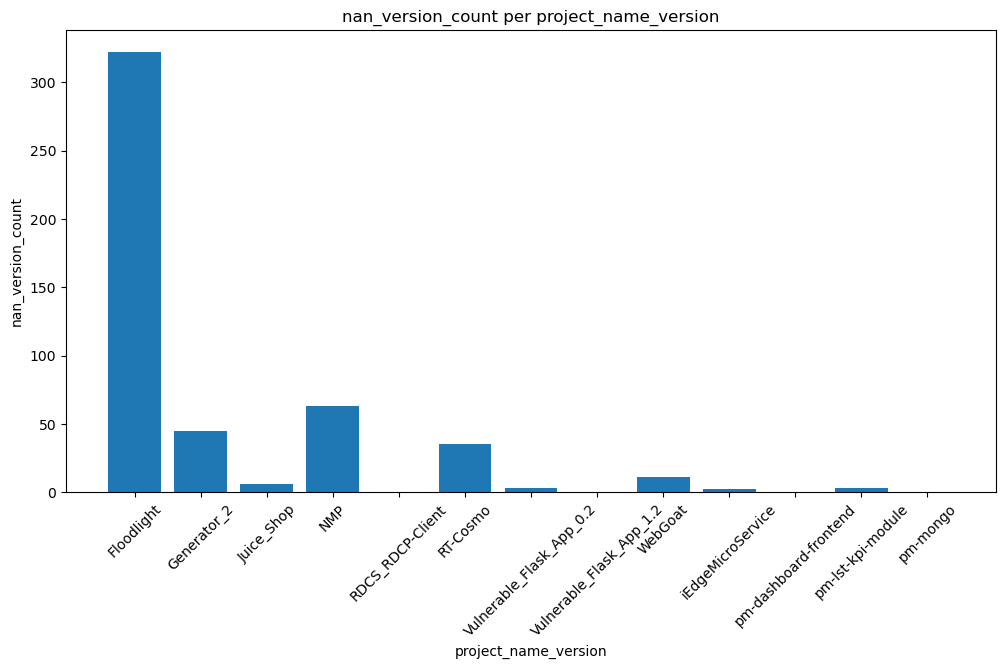

In [63]:
import matplotlib.pyplot as plt

# Plot nan_version_count per project_name_version
plt.figure(figsize=(12, 6))
plt.bar(result.index.get_level_values('project_name_version'), result['nan_version_count'])
plt.xlabel('project_name_version')
plt.ylabel('nan_version_count')
plt.title('nan_version_count per project_name_version')
plt.xticks(rotation=45)
plt.show()

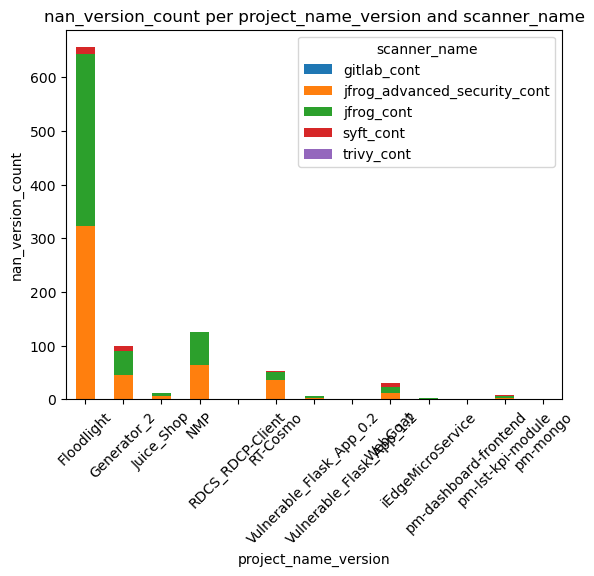

<Figure size 600x300 with 0 Axes>

In [64]:
%matplotlib inline

# Plot nan_version_count per project_name_version and scanner_name

result.reset_index().pivot(index='project_name_version', columns='scanner_name', values='nan_version_count').plot(kind='bar', stacked=True)
plt.xlabel('project_name_version')
plt.ylabel('nan_version_count')
plt.title('nan_version_count per project_name_version and scanner_name')
plt.xticks(rotation=45)
plt.legend(title='scanner_name')
plt.figure(figsize=(6, 3))
plt.show()

<Figure size 600x300 with 0 Axes>

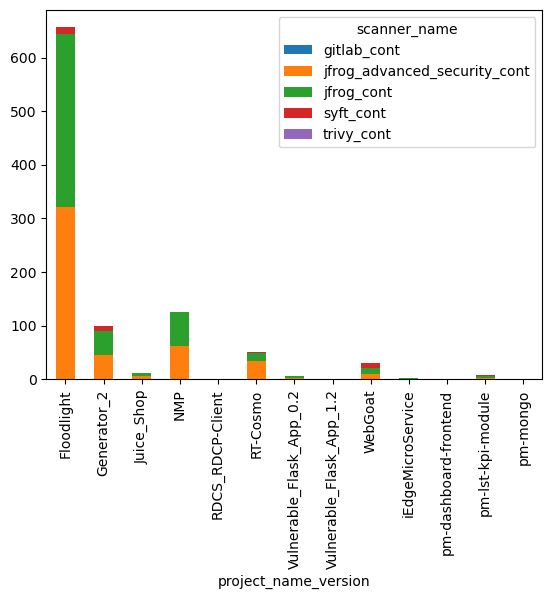

<Figure size 600x300 with 0 Axes>

In [61]:
df = result.reset_index().pivot(index='project_name_version', columns='scanner_name', values='nan_version_count')
df.plot(kind='bar', stacked=True)
plt.figure(figsize=(6, 3))

<Figure size 600x300 with 0 Axes>

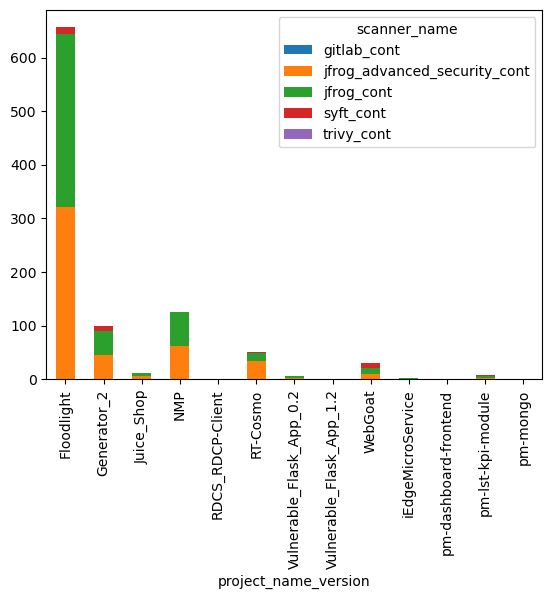

In [62]:
# Assuming you have a DataFrame named result
df = result.reset_index().pivot(index='project_name_version', columns='scanner_name', values='nan_version_count')

# Set the figure size before creating the plot
plt.figure(figsize=(6, 3))

# Create the bar plot
df.plot(kind='bar', stacked=True)

# Show the plot
plt.show()

#### Save artifacts

##### Floodlight artifacts with no version

In [11]:
ind_mask = ((scanner_data_agg_df['project_name_version'] == 'Floodlight') & 
            (scanner_data_agg_df['scanner_name'] == 'jfrog_advanced_security_cont') &
            (scanner_data_agg_df['version'].isna()))
scanner_data_agg_df[ind_mask]['name_version'].str.rstrip(':').to_csv('../output/Floodlight/Floodlight_JFrog_AS_artifacts_with_no_version.csv', index=False)

##### Floodlight artifacts with version (Syft)

In [29]:
ind_mask = ((confusion_matrix_agg_df['project_name_version'] == 'Floodlight') & 
            (confusion_matrix_agg_df['scanner_name'] == 'syft_cont') & 
            (confusion_matrix_agg_df['flag'] == 1) &
            (confusion_matrix_agg_df['label'] == '0'))
df = confusion_matrix_agg_df[ind_mask]

target_file = '../output/Floodlight/Floodlight_Syft_artifacts_with_version.csv'
df[['name', 'version']].to_csv(target_file, index=False)

In [12]:
confusion_matrix_agg_df.columns

Index(['project_name_version', 'scanner_name', 'name_version', 'flag', 'name',
       'version', 'label', 'vote'],
      dtype='object')